필수 컬럼 확인 완료. 분석을 시작합니다.


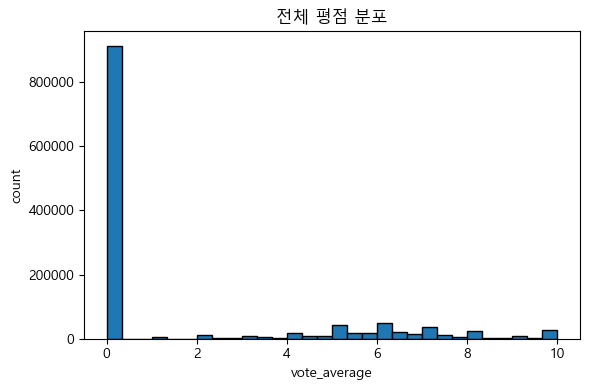

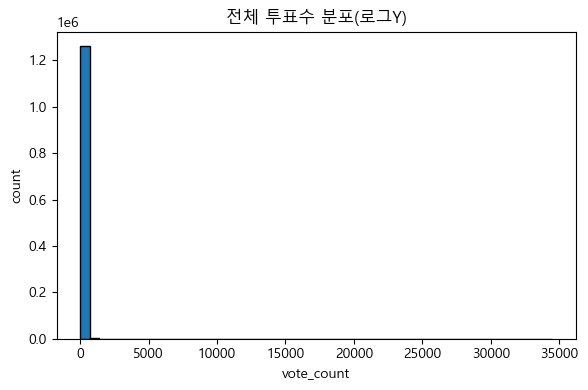

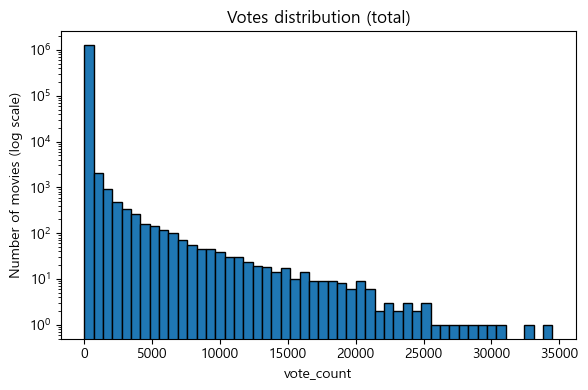

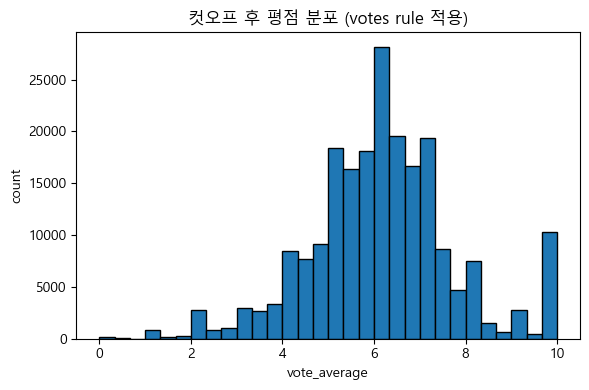


=== 평점 구간별 비율(%) ===
 rating_category
기타     60.42
평범     24.15
성공      4.52
대성공    10.90
Name: count, dtype: float64

=== 장르별 고유 영화 수 및 전체 대비 비율(컷오프 적용 후) ===
               genre  unique_movie_count  percentage_unique
3            Comedy               35773              29.27
16         Thriller               17636              14.43
6             Drama               16637              13.61
5       Documentary               15590              12.76
13          Romance               15491              12.68
0            Action               14685              12.02
10           Horror               14499              11.86
4             Crime                9641               7.89
2         Animation                8566               7.01
15         TV Movie                8270               6.77
7            Family                7938               6.50
14  Science Fiction                7374               6.03
1         Adventure                7127               5.83
8           

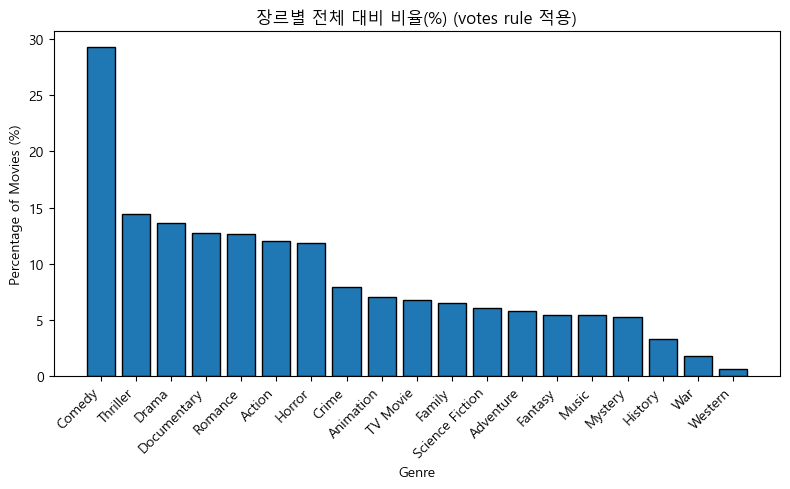

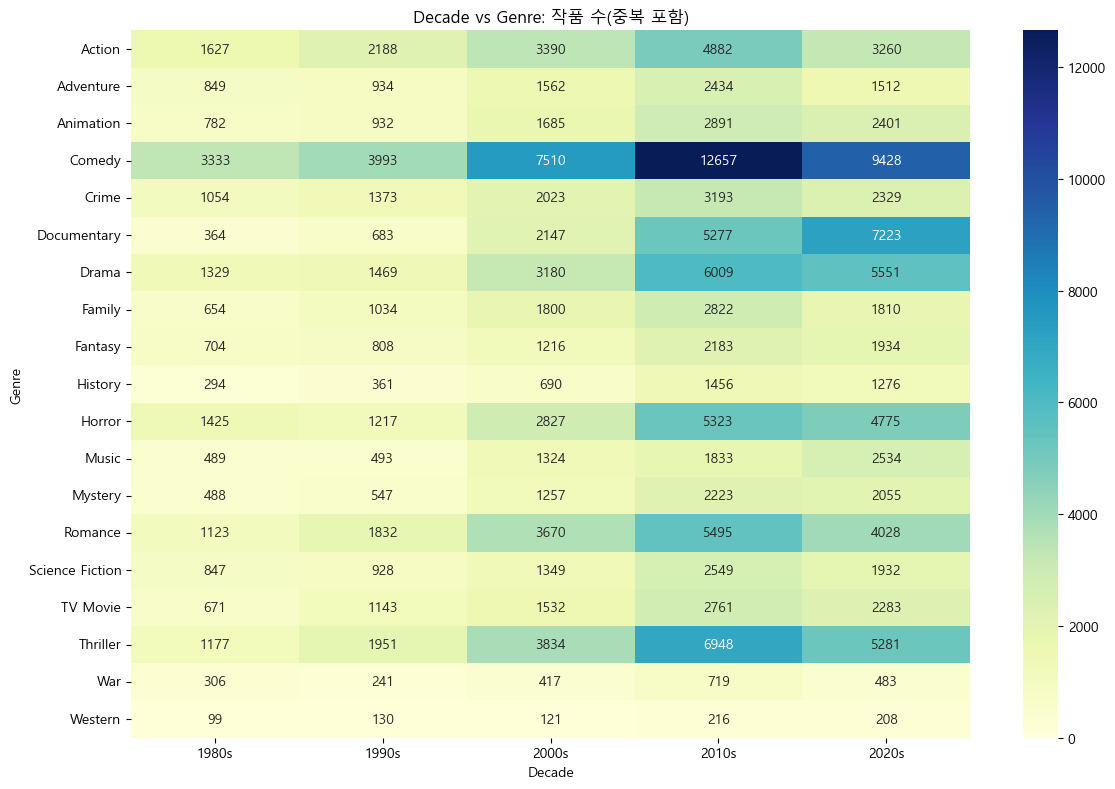

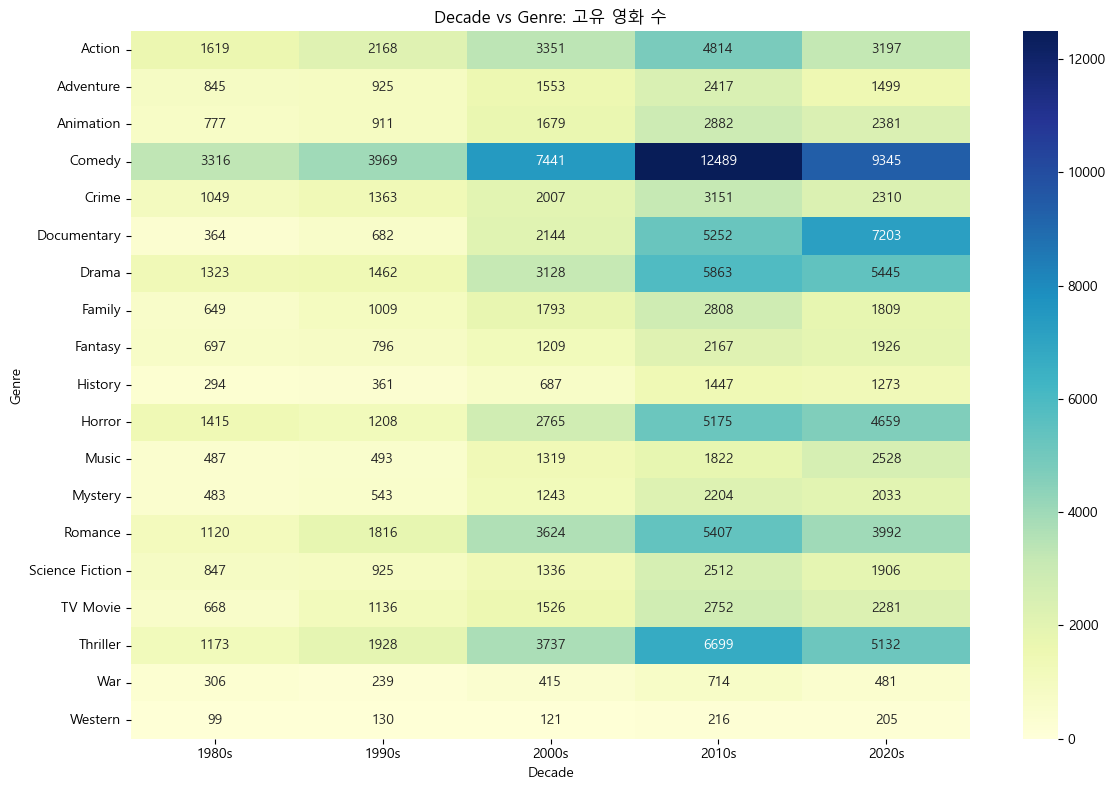

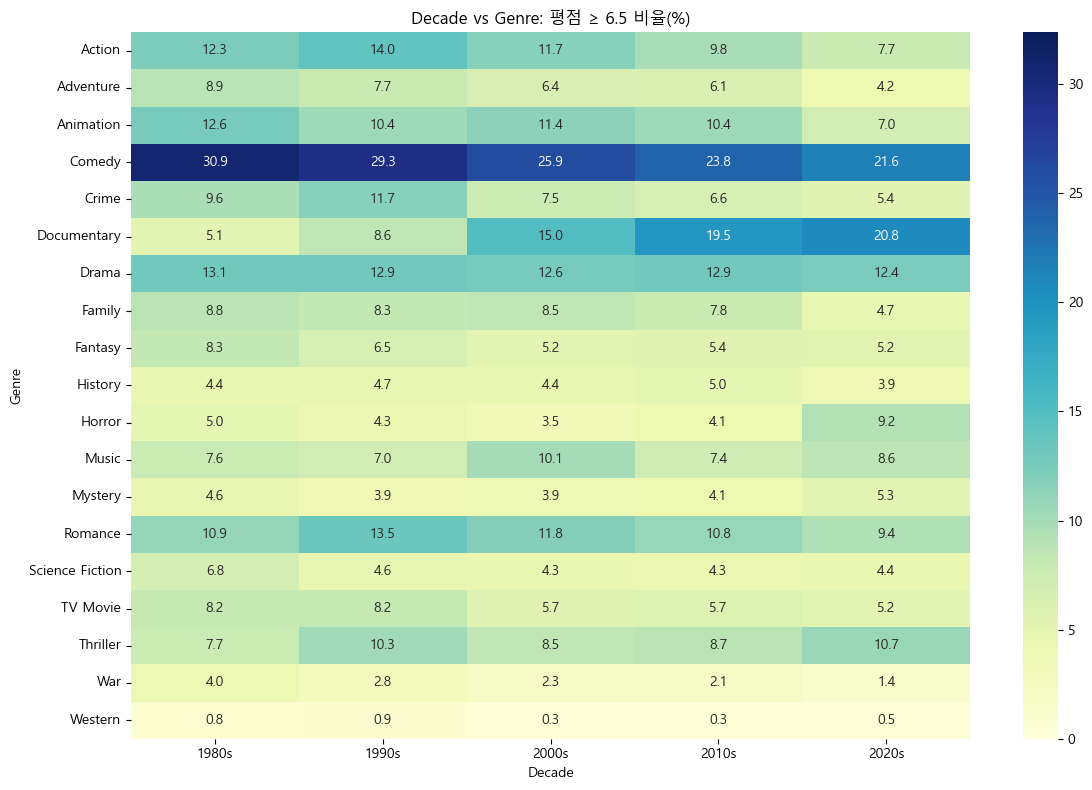

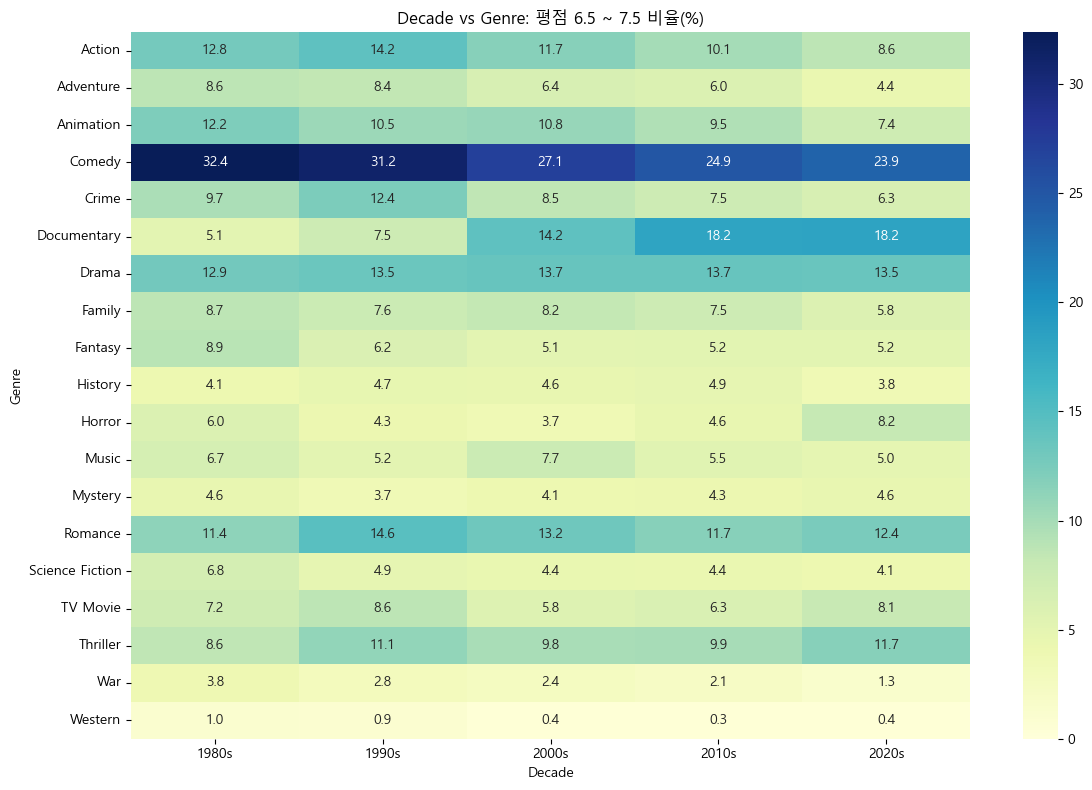

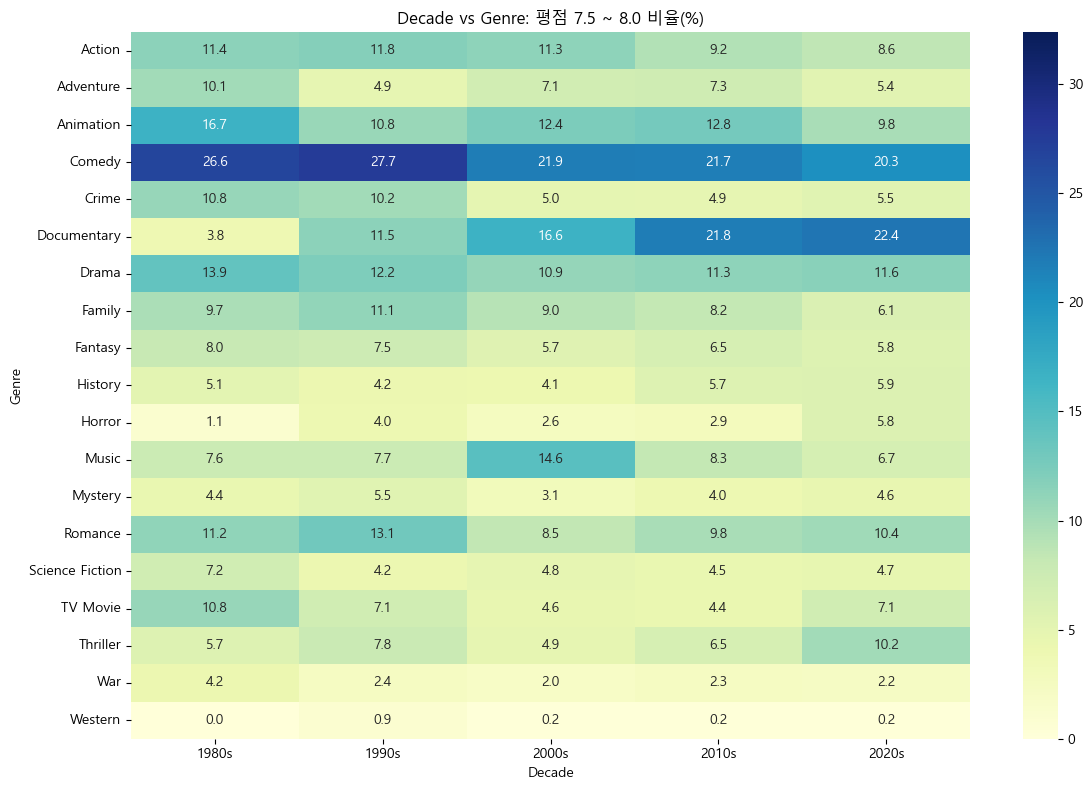

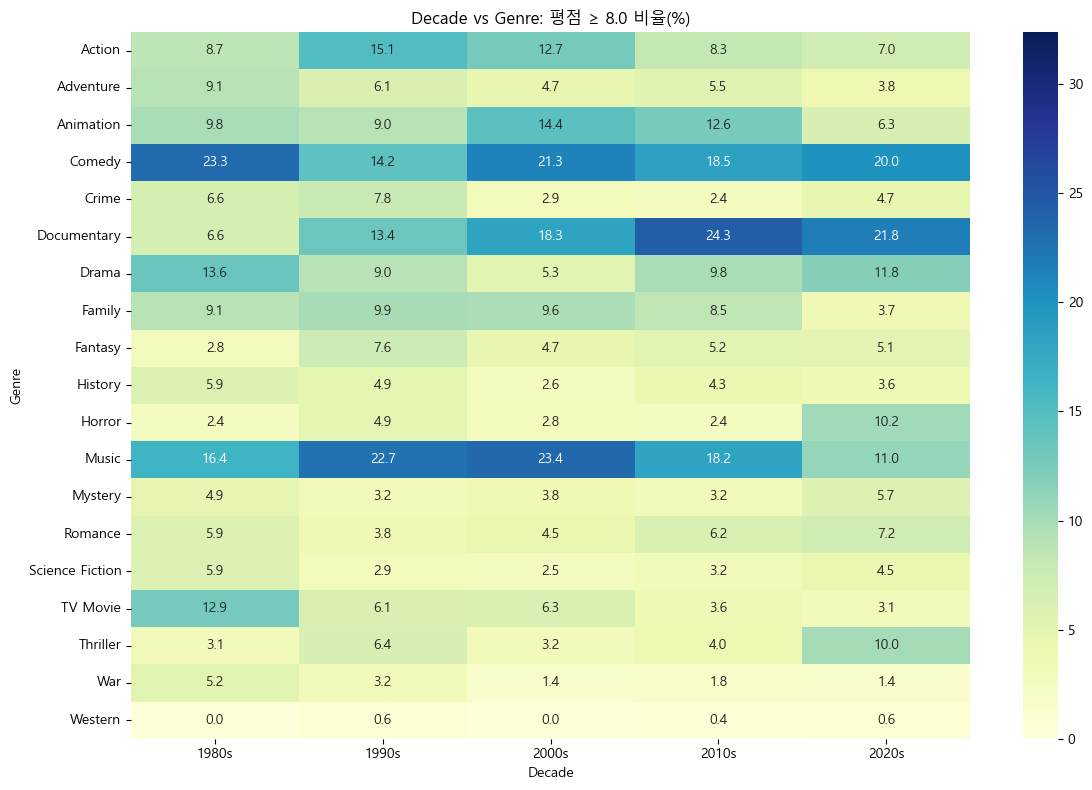

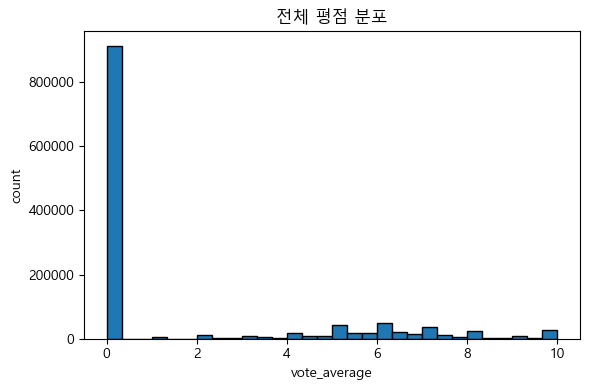

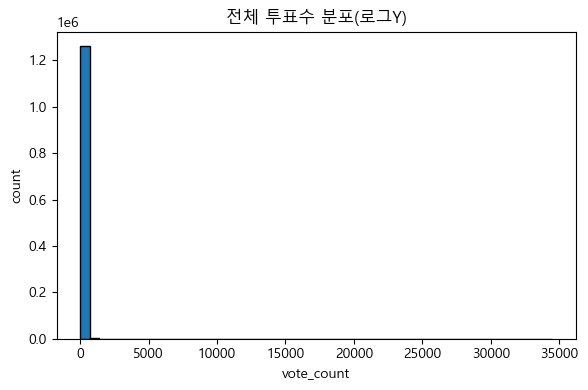

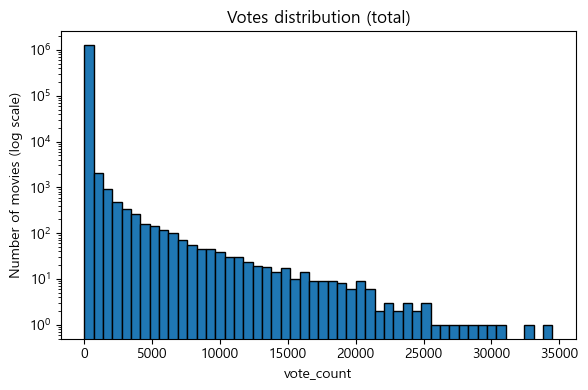

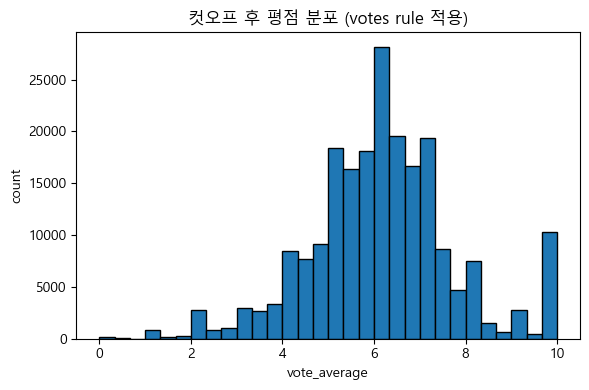


=== 평점 구간별 비율(%) ===
 rating_category
기타     60.42
평범     24.15
성공      4.52
대성공    10.90
Name: count, dtype: float64

=== 장르별 고유 영화 수 및 전체 대비 비율(컷오프 적용 후) ===
               genre  unique_movie_count  percentage_unique
3            Comedy               35773              29.27
16         Thriller               17636              14.43
6             Drama               16637              13.61
5       Documentary               15590              12.76
13          Romance               15491              12.68
0            Action               14685              12.02
10           Horror               14499              11.86
4             Crime                9641               7.89
2         Animation                8566               7.01
15         TV Movie                8270               6.77
7            Family                7938               6.50
14  Science Fiction                7374               6.03
1         Adventure                7127               5.83
8           

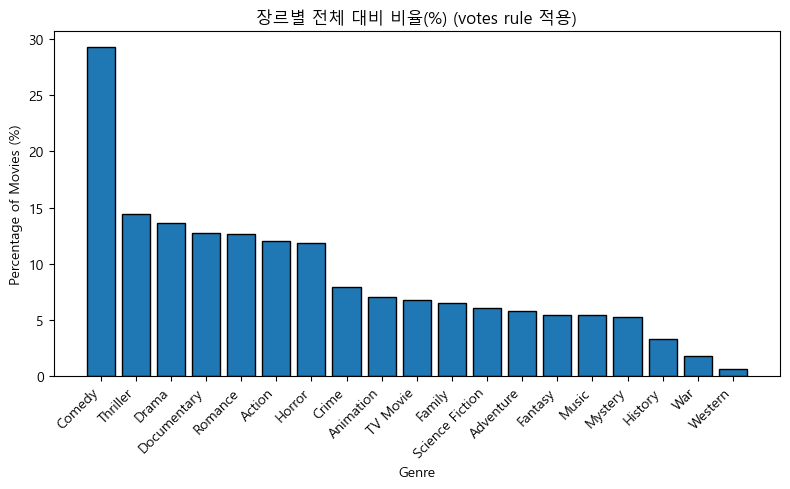

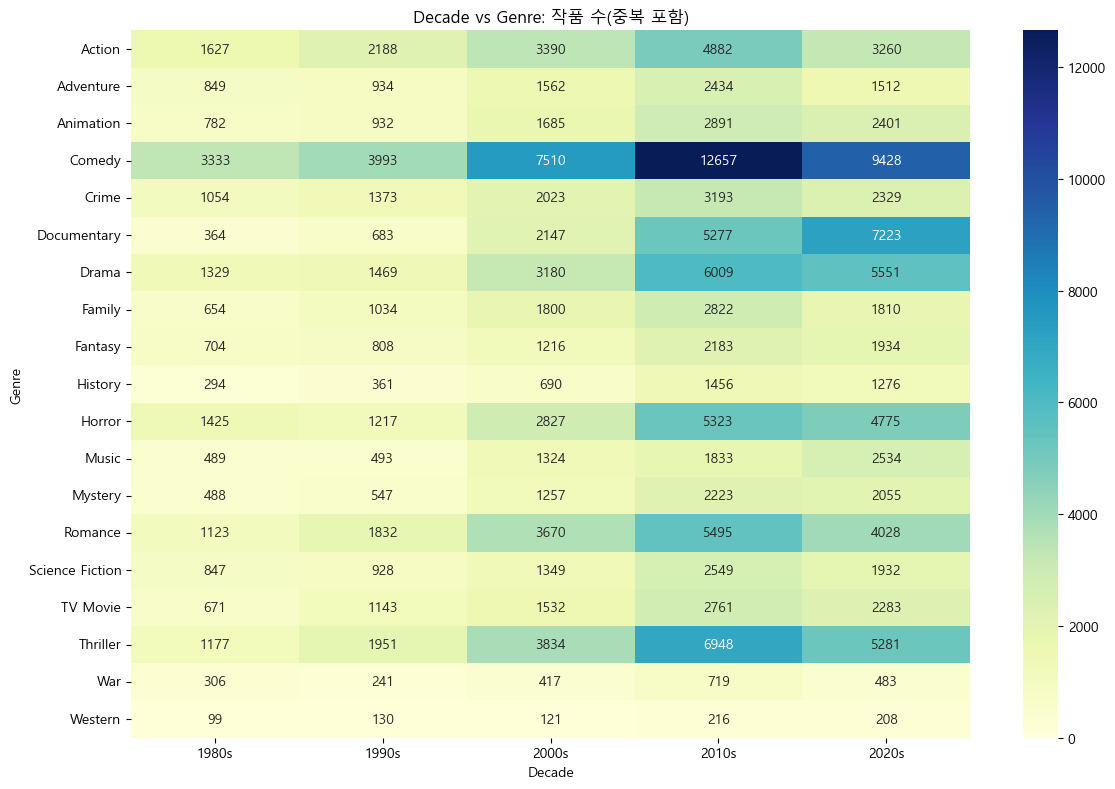

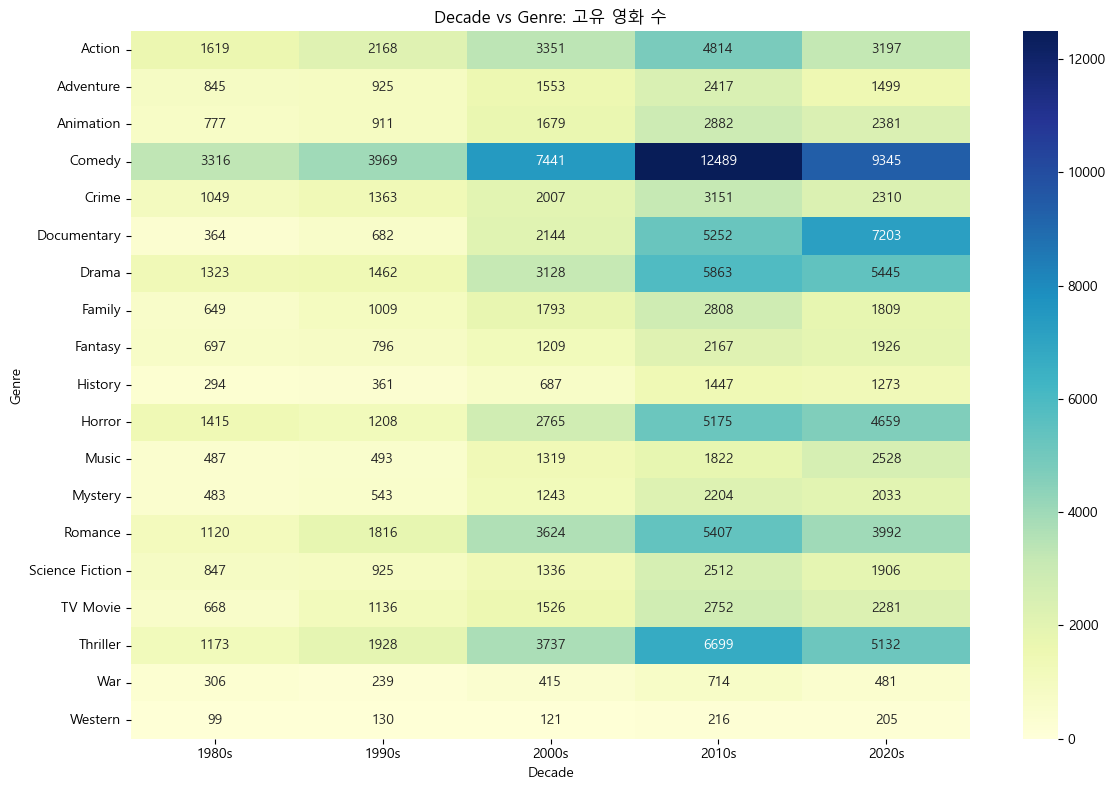

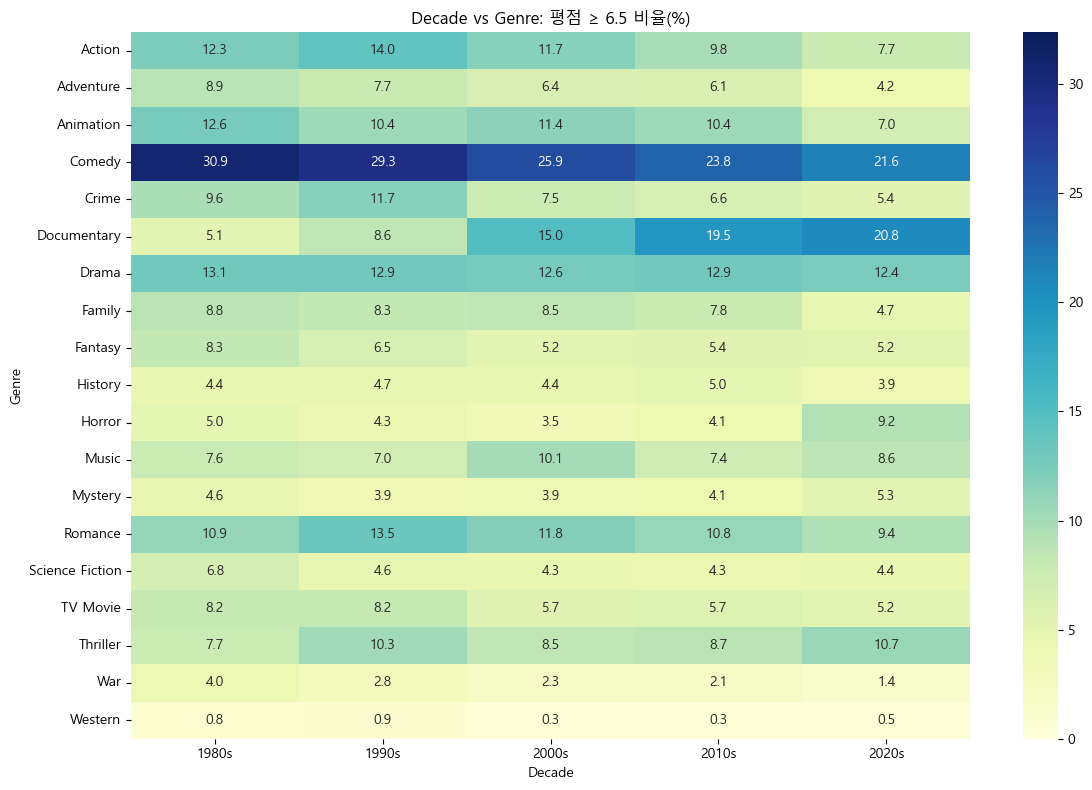

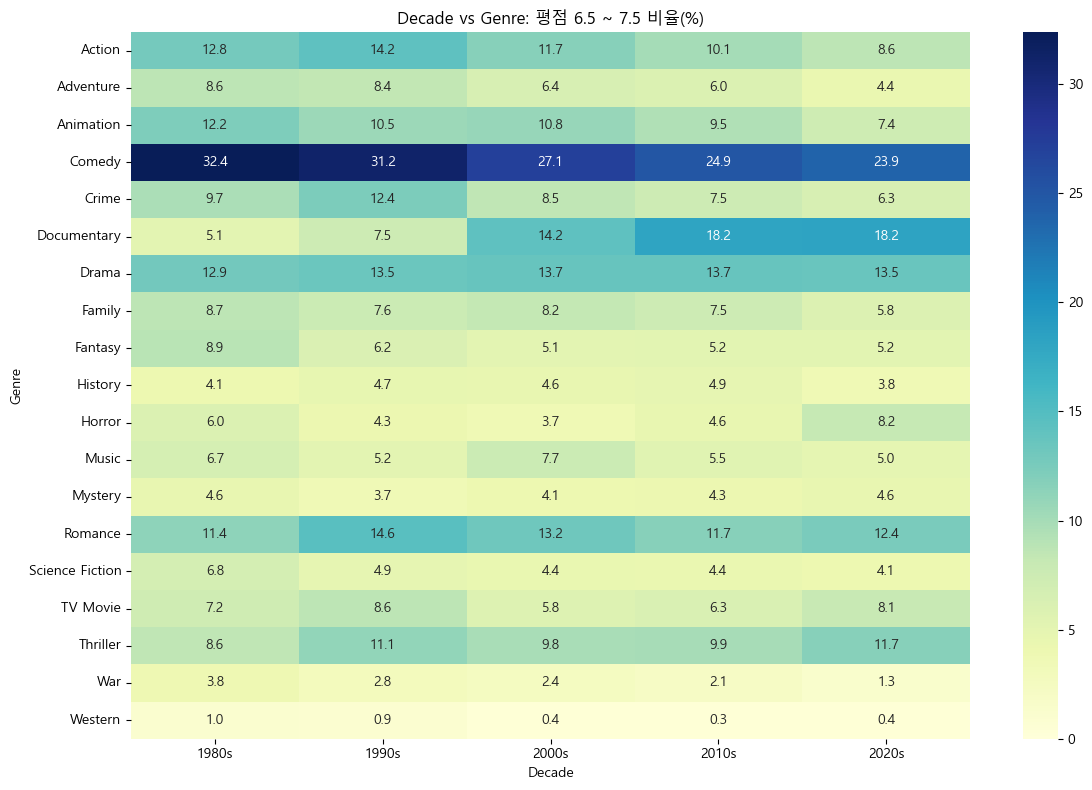

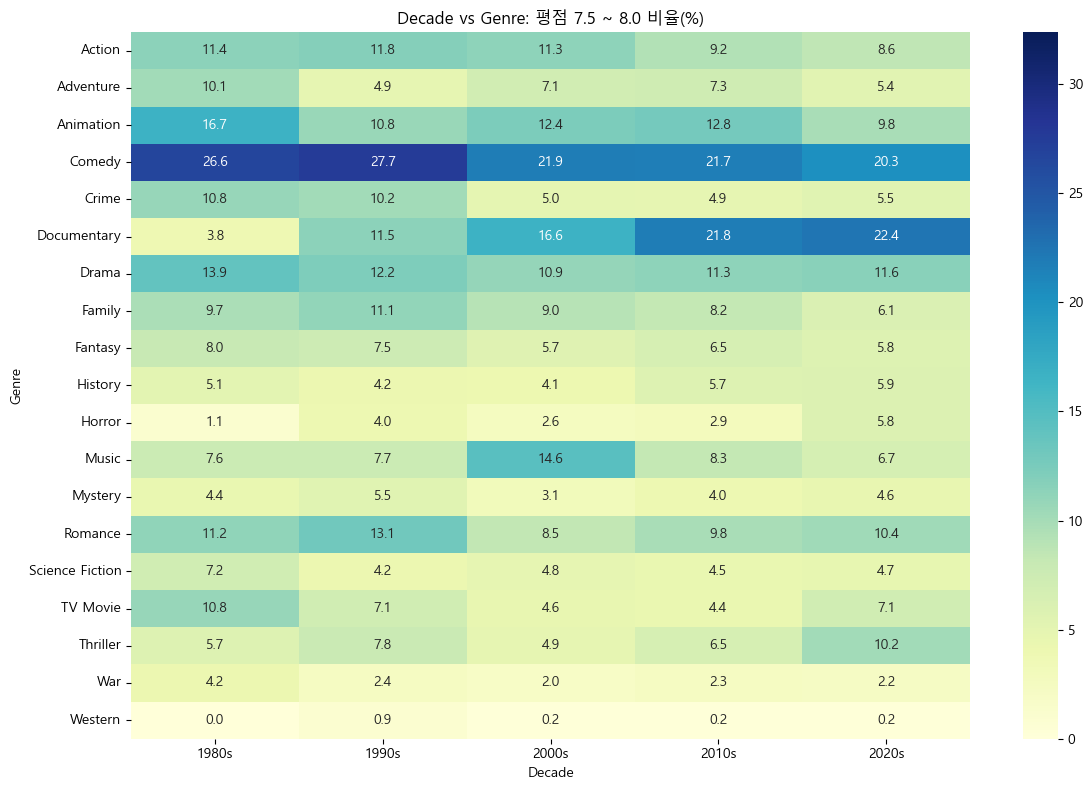

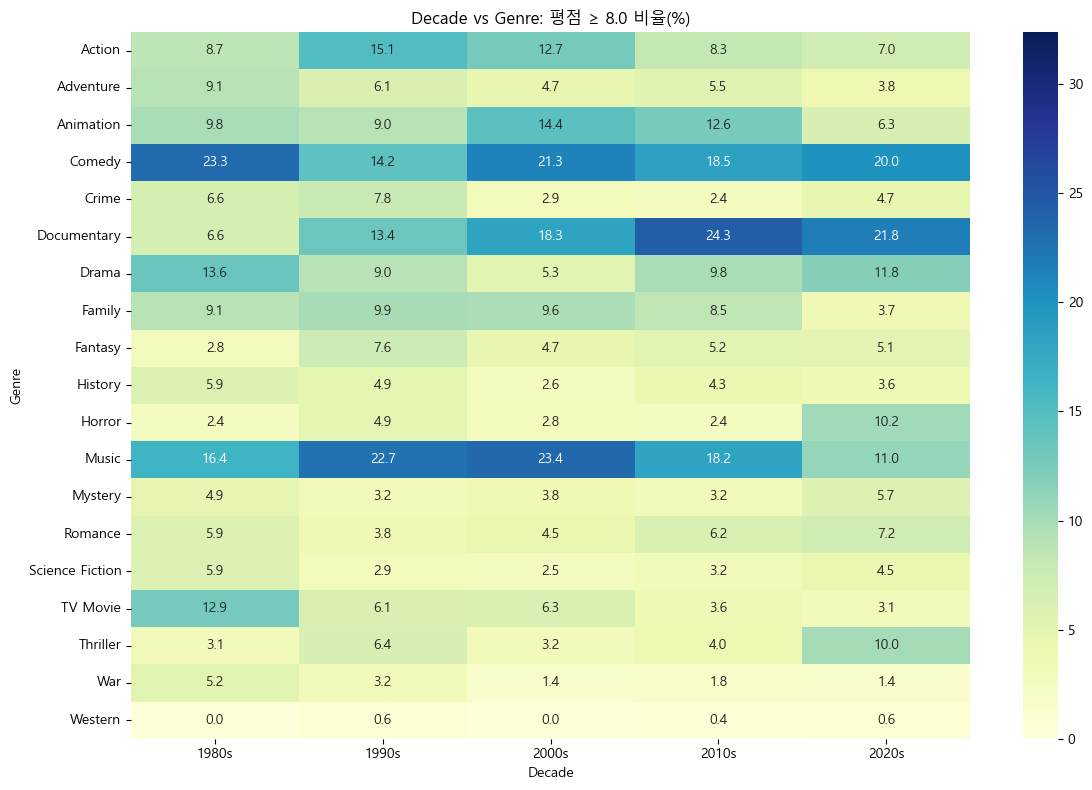

샘플 수: 129958
특징 수: 24
사용 Decade: ['decade_1980s', 'decade_1990s', 'decade_2000s', 'decade_2010s', 'decade_2020s']
사용 장르(Top-K): ['genre_Comedy', 'genre_Thriller', 'genre_Drama', 'genre_Documentary', 'genre_Romance', 'genre_Action', 'genre_Horror', 'genre_Crime', 'genre_Animation', 'genre_TV Movie'] ...
타겟 분포(분류):
vote_average
기타     76648
평범     31397
대성공    15866
성공      6047
Name: count, dtype: int64
              precision    recall  f1-score   support

          기타      0.744     0.566     0.643     15330
         대성공      0.326     0.775     0.459      3173
          성공      0.098     0.359     0.154      1209
          평범      0.329     0.124     0.180      6280

    accuracy                          0.475     25992
   macro avg      0.374     0.456     0.359     25992
weighted avg      0.563     0.475     0.486     25992


[1단계] 분류 리포트 (기타 vs 상위)
              precision    recall  f1-score   support

          기타      0.718     0.687     0.702     15330
          상위      0.576  

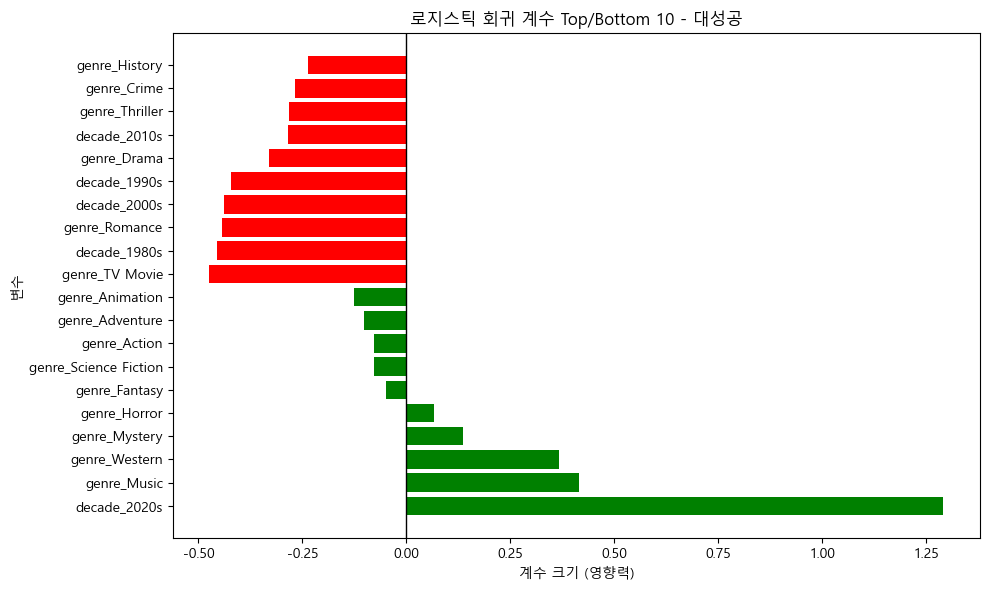

C:\Users\yj-603-02\AppData\Local\Temp\ipykernel_4156\3082113180.py:1634: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df.head(15), x='importance', y='feature', palette='viridis')


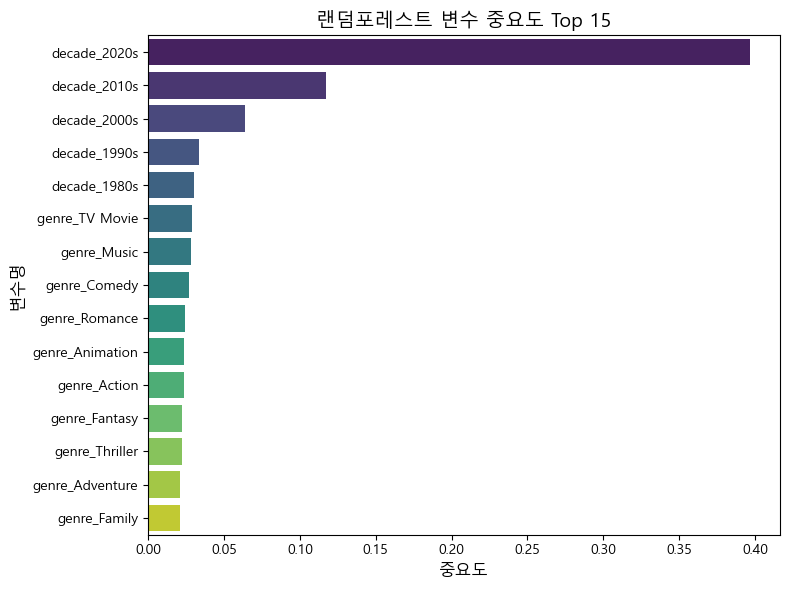

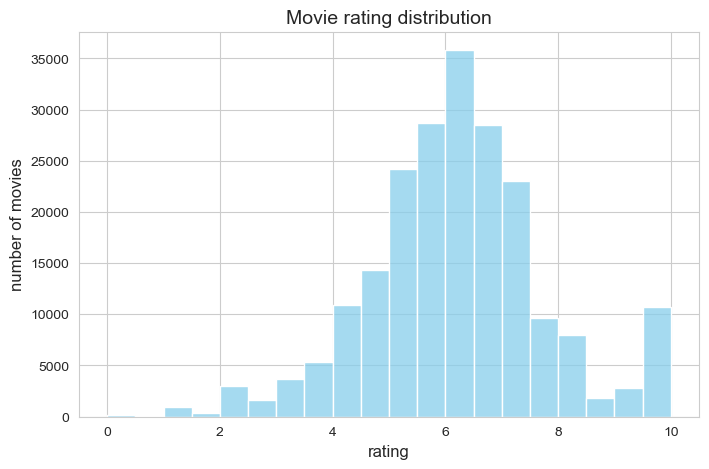

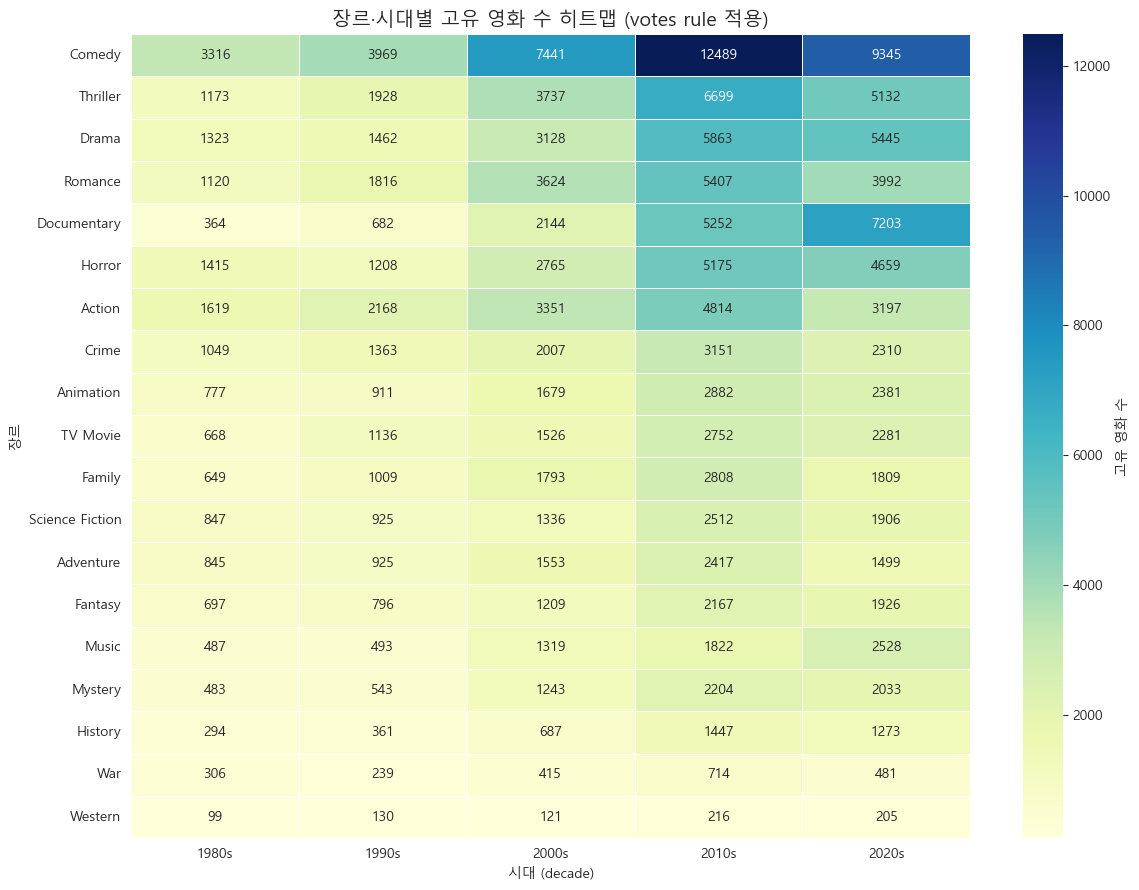

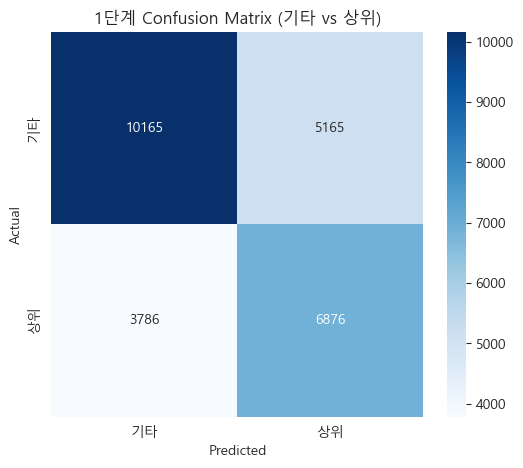

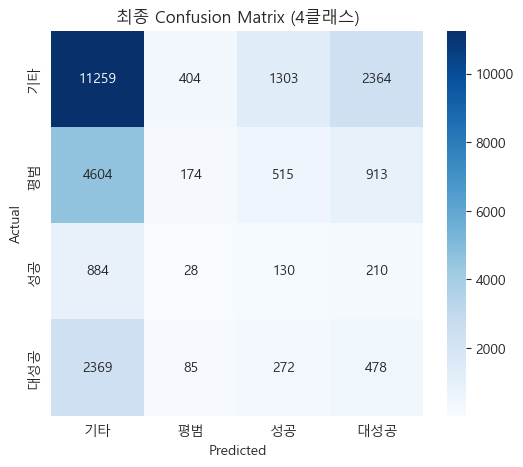

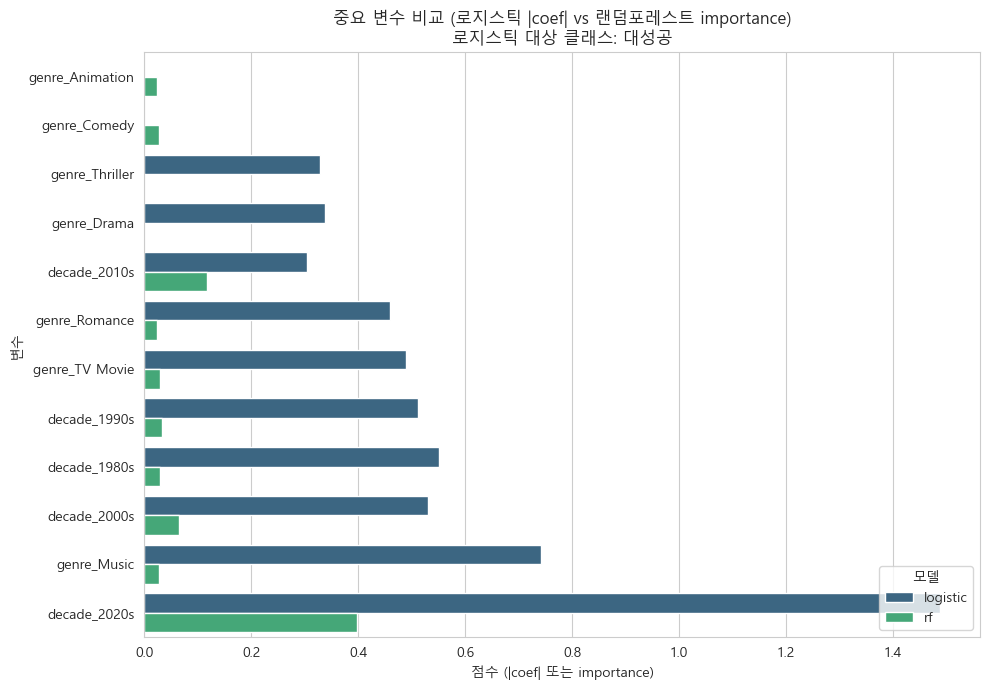

'\n이번 프로젝트는 처음으로 데이터 분석과 머신러닝을 실제로 적용해보는 것을 목표로 시작했습니다.\n장르별 평점과 시대별 흐름을 분석하여 앞으로 나올 영화가 어떤 평점을 받을지 예측하고자 했습니다.\n\n진행 과정에서 다음과 같은 성과와 깨달음을 얻었습니다.\n\n - 처음부터 끝까지 전 과정을 수행하며 데이터 전처리 → 분석 → 모델링 → 시각화까지의 흐름을 경험.\n - 로지스틱 회귀와 랜덤포레스트를 적용하여 장르·시대 기반 평점 예측 가능성을 확인.\n - 모델별 특성과 장단점을 비교하며 상황에 맞는 모델 선택의 중요성을 이해.\n - 데이터 품질(투표 수 불균형, 편향된 평점)과 피처 부족이 성능의 주요 한계임을 체감.\n\n비록 예측 성능에는 한계가 있었지만,\n이번 프로젝트는 데이터 분석 기초 역량 강화와 머신러닝 모델 이해에 큰 의미가 있었으며,\n향후 더 다양한 특성과 정제된 데이터를 활용하면 성능을 크게 개선할 수 있을 것이라는 가능성을 확인했습니다.\n'

In [1]:
# -*- coding: utf-8 -*-
"""
Refactored TMDB analysis script
- 목표: 전처리/분석 함수화, 변수명 구체화, 시각화 표준화, 코드 중복 최소화
- 주제: 평점 분포/구간화 + 장르/시대 분석 (ROI 분석 제외)
"""

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) 전역 설정
# ------------------------------------------------------------
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# 시각화 표준: 폰트(윈도우 맑은고딕), 마이너스 표시
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)


# ------------------------------------------------------------
# 1) 유틸 함수들 (전처리)
# ------------------------------------------------------------
def to_numeric_safe(x):
    """문자열/숫자 혼합 데이터를 안전하게 숫자(float)로 변환. 변환 실패 시 NaN."""
    try:
        if isinstance(x, str):
            x = x.replace(",", "").strip()
        return pd.to_numeric(x, errors="coerce")
    except Exception:
        return np.nan


def parse_genres(val):
    """genres 컬럼을 '장르명 리스트'로 변환."""
    # 이미 리스트인 경우
    if isinstance(val, list):
        names = []
        for item in val:
            if isinstance(item, dict) and "name" in item:
                names.append(str(item["name"]).strip())
            else:
                names.append(str(item).strip())
        return names

    # 문자열인 경우
    if isinstance(val, str):
        s = val.strip()
        if s in ("", "[]"):
            return []
        # JSON 문자열 파싱 시도(단일 인용부호 → 이중 인용부호 치환)
        try:
            obj = json.loads(s.replace("'", '"'))
            if isinstance(obj, list):
                names = []
                for item in obj:
                    if isinstance(item, dict) and "name" in item:
                        names.append(str(item["name"]).strip())
                    else:
                        names.append(str(item).strip())
                return names
        except Exception:
            pass
        # 콤마 구분
        if "," in s:
            return [tok.strip() for tok in s.split(",") if tok.strip()]
        # 그 외 단일 문자열
        return [s]

    # 그 외 타입(숫자/NaN 등)
    return []


def filter_genres(genres_list, exclude_if_combined=None):
    """
    드라마/다큐멘터리는 단일 장르일 때만 인정.
    다른 장르와 함께 있으면 제외.
    """
    if exclude_if_combined is None:
        exclude_if_combined = ["Drama", "Documentary"]

    if not isinstance(genres_list, list):
        return []

    if len(genres_list) == 1:
        return genres_list

    return [g for g in genres_list if g not in exclude_if_combined]


def ensure_datetime(df, date_col="release_date"):
    """문자열 날짜를 datetime으로 변환(NaT 허용)."""
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    return out


def add_year_and_decade(df, date_col="release_date"):
    """연도(year), 시대(decade: '1980s') 컬럼 추가."""
    out = df.copy()
    out["year"] = out[date_col].dt.year.astype("Int64")
    out = out[out["year"].notna()].copy()
    out["year"] = out["year"].astype(int)
    out["decade"] = ((out["year"] // 10) * 10).astype(str) + "s"
    return out


def explode_genres(df, src="genres_filtered", dst="genre"):
    """장르 리스트를 행으로 분리. 공백/결측 제거."""
    out = df.copy()
    if src != dst:
        out = out.rename(columns={src: dst})
    out = out.explode(dst)
    out = out[out[dst].notna() & (out[dst].astype(str).str.strip() != "")].copy()
    out[dst] = out[dst].astype(str).str.strip()
    return out


def apply_vote_cut_rules(df, year_col="year", vote_col="vote_count"):
    """
    투표 컷오프 규칙 적용:
      - 1980~2019: ≥ 4표
      - 2020~2025: ≥ 1표
    분석 범위는 1980~2025로 제한.
    """
    base = df[(df[year_col] >= 1980) & (df[year_col] <= 2025)].copy()
    early = base[(base[year_col] < 2020) & (base[vote_col] >= 4)]
    late = base[(base[year_col] >= 2020) & (base[vote_col] >= 1)]
    return pd.concat([early, late], ignore_index=True)


def categorize_rating(v):
    """평점 구간 분류: 기타 / 평범(6.5~<7.5) / 성공(7.5~<8.0) / 대성공(>=8.0)."""
    if v >= 8.0:
        return "대성공"
    elif v >= 7.5:
        return "성공"
    elif v >= 6.5:
        return "평범"
    else:
        return "기타"


# ------------------------------------------------------------
# 2) 시각화 헬퍼 (표준화)
#   - vmin/vmax, figsize, 라벨 회전 등 공통 설정
#   - seaborn 대신 matplotlib로도 표현 가능하지만, 여기서는 단순화 위해 seaborn 사용
#   - 동일 스케일 비교를 위해 vmin/vmax 인자로 고정값 전달 가능
# ------------------------------------------------------------
def plot_hist(series, bins=30, title="", xlabel="", ylabel="count"):
    """히스토그램 표준 출력."""
    plt.figure(figsize=(6, 4))
    plt.hist(series.dropna(), bins=bins, edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def plot_bar(x, y, title="", xlabel="", ylabel="", rotate=45):
    """막대그래프 표준 출력."""
    plt.figure(figsize=(8, 5))
    plt.bar(x, y, edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()


def plot_heatmap(pivot_df, title="", fmt=".1f", vmin=None, vmax=None):
    """히트맵 표준 출력 (seaborn)."""
    import seaborn as sns  # 지역 임포트
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt=fmt, cmap="YlGnBu", vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.ylabel("Genre")
    plt.xlabel("Decade")
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 3) 분석 도우미
# ------------------------------------------------------------
def compute_genre_share(df, group_cols=("genre",), title_col="title"):
    """
    장르별 고유 영화 수 및 전체 대비 비율 계산.
    반환: DataFrame['genre', 'unique_movie_count', 'percentage_unique']
    """
    total_unique = df[title_col].nunique()
    genre_unique_counts = (
        df.groupby(list(group_cols))[title_col]
        .nunique()
        .reset_index()
        .rename(columns={title_col: "unique_movie_count"})
    )
    genre_unique_counts["percentage_unique"] = (
        genre_unique_counts["unique_movie_count"] / total_unique * 100
    ).round(2)
    return genre_unique_counts.sort_values("unique_movie_count", ascending=False)


def pivot_decade_genre_counts(df, count_col="title", agg="count"):
    """
    시대(decade) × 장르별 영화 수 피벗 생성.
    count_col 기준으로 'count' 또는 'nunique' 집계 선택.
    """
    if agg == "nunique":
        grouped = (
            df.groupby(["decade", "genre"])[count_col]
            .nunique()
            .reset_index(name="movie_count")
        )
    else:
        grouped = (
            df.groupby(["decade", "genre"])[count_col]
            .count()
            .reset_index(name="movie_count")
        )
    return grouped.pivot(index="genre", columns="decade", values="movie_count").fillna(0)


def analyze_rating_band(df_base, rating_min=None, rating_max=None):
    """
    주어진 평점 구간의 데이터만 필터링하여
    (1) 시대×장르 고유 영화 수
    (2) 각 시대 내 장르 비율(%)
    (3) 히트맵용 피벗
    을 반환.
    """
    filt = df_base.copy()
    if rating_min is not None:
        filt = filt[filt["vote_average"] >= rating_min]
    if rating_max is not None:
        filt = filt[filt["vote_average"] < rating_max]

    # 시대×장르 고유 영화 수
    counts = (
        filt.groupby(["genre", "decade"])["title"]
        .nunique()
        .reset_index(name="movie_count")
    )

    # 각 시대별 전체 영화 수 (해당 평점 구간 내에서)
    totals = (
        filt.groupby("decade")["title"]
        .nunique()
        .to_dict()
    )

    # 비율 계산
    counts["percentage"] = counts.apply(
        lambda row: (row["movie_count"] / totals[row["decade"]] * 100) if totals.get(row["decade"], 0) else 0.0,
        axis=1
    ).round(2)

    # 피벗(히트맵용, %)
    pivot_pct = counts.pivot(index="genre", columns="decade", values="percentage").fillna(0)

    return counts, pivot_pct


# ------------------------------------------------------------
# 4) 메인 파이프라인
# ------------------------------------------------------------
def preprocess_data(df_raw):
    """
    원천 df → 전처리 df 생성:
      - 숫자형 변환(vote_average, revenue, budget)
      - 장르 파싱/필터링
      - 날짜 변환/연, decade 추가
    """
    df_pre = df_raw.copy()

    # 숫자형 변환
    for col in ["vote_average", "revenue", "budget"]:
        if col in df_pre.columns:
            df_pre[col] = df_pre[col].apply(to_numeric_safe)

    # 장르 파싱/필터링
    df_pre["genres_parsed"] = df_pre["genres"].apply(parse_genres)
    df_pre["genres_filtered"] = df_pre["genres_parsed"].apply(filter_genres)

    # 날짜 → datetime
    df_pre = ensure_datetime(df_pre, "release_date")
    # 연/decade
    df_pre = add_year_and_decade(df_pre, "release_date")

    return df_pre


def build_base_dataset(df_pre):
    """
    - 장르 explode
    - 투표컷 적용(1980~2019: ≥4표, 2020~2025: ≥1표)
    """
    df_exploded = explode_genres(df_pre, src="genres_filtered", dst="genre")
    df_cut = apply_vote_cut_rules(df_exploded, year_col="year", vote_col="vote_count")
    return df_exploded, df_cut  # (장르 explode만 적용된 df, 컷오프까지 적용된 df)


def run_analysis(df_raw):
    """
    전체 파이프라인 실행:
      1) 전처리
      2) 장르 explode & 컷오프
      3) EDA(분포/구간화)
      4) 장르/시대 분석 + 구간별 분석
    """
    # 1) 전처리
    df_pre = preprocess_data(df_raw)

    # 2) explode & 컷오프
    df_exploded_all, df_base = build_base_dataset(df_pre)

    # 3) EDA 1 - 평점/투표 분포
    if "vote_average" in df_raw.columns:
        plot_hist(df_raw["vote_average"], bins=30, title="전체 평점 분포", xlabel="vote_average")
    if "vote_count" in df_raw.columns:
        plot_hist(df_raw["vote_count"], bins=50, title="전체 투표수 분포(로그Y)", xlabel="vote_count")
        # 로그 y축 표현을 단일 헬퍼에 넣지 않고, 필요 시 직접 지정
        plt.figure(figsize=(6, 4))
        plt.hist(df_raw["vote_count"].dropna(), bins=50, edgecolor="black")
        plt.yscale("log")
        plt.title("Votes distribution (total)")
        plt.xlabel("vote_count")
        plt.ylabel("Number of movies (log scale)")
        plt.tight_layout()
        plt.show()

    # 컷오프 후 평점 분포
    plot_hist(df_base["vote_average"], bins=30, title="컷오프 후 평점 분포 (votes rule 적용)", xlabel="vote_average")

    # 4) EDA 2 - 평점 구간화
    #    : 단순 참고용 출력(필요 시 비활성화 가능)
    df_base["rating_category"] = df_base["vote_average"].apply(categorize_rating)
    cat_counts = df_base["rating_category"].value_counts().reindex(["기타", "평범", "성공", "대성공"])
    cat_ratios = (cat_counts / len(df_base) * 100).round(2)
    print("\n=== 평점 구간별 비율(%) ===\n", cat_ratios)

    # 5) 장르 전체 비율(컷오프 적용 후)
    genre_share = compute_genre_share(df_base, group_cols=("genre",), title_col="title")
    print("\n=== 장르별 고유 영화 수 및 전체 대비 비율(컷오프 적용 후) ===\n", genre_share.head(15))
    plot_bar(
        x=genre_share["genre"],
        y=genre_share["percentage_unique"],
        title="장르별 전체 대비 비율(%) (votes rule 적용)",
        xlabel="Genre",
        ylabel="Percentage of Movies (%)"
    )

    # 6) 시대×장르: (A) 단순 개수 (B) 고유 개수
    pivot_count = pivot_decade_genre_counts(df_base, count_col="title", agg="count")
    pivot_unique = pivot_decade_genre_counts(df_base, count_col="title", agg="nunique")

    # 히트맵 시각화 범위 표준화: 0~pivot의 공통 최대값
    vmax_count = pivot_count.values.max() if len(pivot_count.values) else None
    vmax_unique = pivot_unique.values.max() if len(pivot_unique.values) else None

    plot_heatmap(pivot_count, title="Decade vs Genre: 작품 수(중복 포함)", fmt=".0f", vmin=0, vmax=vmax_count)
    plot_heatmap(pivot_unique, title="Decade vs Genre: 고유 영화 수", fmt=".0f", vmin=0, vmax=vmax_unique)

    # 7) 평점 구간 분석: (a) >=6.5, (b) 6.5~7.5, (c) 7.5~8.0, (d) >=8.0

    bands = [
        ("평점 ≥ 6.5", 6.5, None),
        ("평점 6.5 ~ 7.5", 6.5, 7.5),
        ("평점 7.5 ~ 8.0", 7.5, 8.0),
        ("평점 ≥ 8.0", 8.0, None),
    ]
    # 히트맵 공통 스케일(%)를 위해 모든 밴드에서 최대값을 먼저 측정
    pivot_list = []
    vmax_pct = 0.0
    for band_title, vmin, vmax in bands:
        counts_df, pivot_df = analyze_rating_band(df_base, rating_min=vmin, rating_max=vmax)
        pivot_list.append((band_title, pivot_df))
        if not pivot_df.empty:
            vmax_pct = max(vmax_pct, float(pivot_df.values.max()))
    for band_title, pivot_df in pivot_list:
        plot_heatmap(pivot_df, title=f"Decade vs Genre: {band_title} 비율(%)", fmt=".1f", vmin=0, vmax=vmax_pct)

    # 파이프라인 산출물 반환(필요 시 후속 처리 위해)
    return {
        "df_pre": df_pre,
        "df_base": df_base,
        "genre_share": genre_share,
        "pivot_count": pivot_count,
        "pivot_unique": pivot_unique,
        "pivots_pct": {title: pv for title, pv in pivot_list},
    }



# ------------------------------------------------------------
# 5) 스크립트 실행부 (예시)
# ------------------------------------------------------------
if __name__ == "__main__":
    # CSV 경로는 사용자 환경에 맞춰 조정
    CSV_PATH = "TMDB_movie_dataset_v11.csv"

    # 필수 컬럼 존재 여부 사전 점검
    df_raw = pd.read_csv(CSV_PATH)
    required_cols = ["vote_average", "revenue", "budget", "genres", "release_date", "vote_count", "title"]
    missing = [c for c in required_cols if c not in df_raw.columns]
    if missing:
        print("[경고] 다음 컬럼이 존재하지 않습니다:", missing)
        print("→ CSV의 실제 컬럼명을 알려주시면 매핑해서 처리할 수 있습니다.")
    else:
        print("필수 컬럼 확인 완료. 분석을 시작합니다.")
        outputs = run_analysis(df_raw)
        # 필요하다면 여기서 outputs를 파일로 저장하거나 추가 보고서 생성 가능

# 분석 결과

'''
1. 전체 장르 분포 특징
1.1 코미디

모든 시대와 평점 구간에서 높은 비중 유지

1980년대부터 높은 점유율을 보였으나, 시대가 지날수록 소폭 하락

1.2 드라마

전 구간에서 안정적인 중상위 비율 유지

평점 상승 여부와 비율 변화의 상관성은 낮음(중립적)

1.3 다큐멘터리

저평점 구간에서는 비중이 낮으나, 8.0+ 구간에서 급상승

소수 작품이지만 평균 평점이 높음

1.4 뮤직

전체 비중은 작지만, 8.0+ 구간에서 두드러진 강세

1.5 애니메이션

6.5~7.5 구간에서 많이 나타나며, 7.5 이상 구간에서도 안정적인 고평점 비율 유지

1.6 액션

전 시대에 걸쳐 작품 수가 많음

6.5~7.5 구간에서는 무난하나, 8.0+ 구간 비중은 매우 낮음

시각적 볼거리는 강하지만 스토리·작품성이 부족한 경우가 많음

1.7 판타지

8.0+ 구간 비중이 낮고, 7.5~8.0 구간에서도 하위권

높은 제작비와 시리즈물 편중, 실패작 영향으로 평균 평점이 낮아짐

1.8 호러

고평점 비율이 매우 낮음

호불호가 극명하고, 저예산·양산형 작품이 많아 전반적으로 낮은 평가

1.9 로맨스

주로 6.5~7.5 구간에 분포

8.0+ 구간에서는 거의 나타나지 않음

장르 팬층은 선호하지만, 대중 평가는 다소 낮은 편

2. 시대별 변화
1980s

코미디와 드라마가 절대적 우위를 차지

액션과 애니메이션도 높은 비율

8.0+ 구간에서는 뮤직 장르 강세

1990s

여전히 코미디 우세

다큐멘터리·뮤직의 고평점 비중 상승

애니메이션의 고평점 비율 뚜렷

2000s

다큐멘터리 8.0+ 비율 급증

코미디 비율 전반적 감소

액션·애니메이션은 7.5 이상에서 안정적인 비율 유지

2010s

다큐멘터리·뮤직 고평점 비중 최고치

장르 다양성 확대

2020s

전반적으로 고른 장르 분포

다큐멘터리·뮤직은 여전히 고평점 비율 높음

액션·코미디 비중은 과거 대비 하락

추세

2000년대 이후 코미디, 액션, 판타지 등 대중 장르의 고평점 비중이 점진적 하락

3. 평점 구간별 패턴
6.5~7.5 구간

대중적 상업 영화 집중 구간

코미디, 드라마, 액션 중심으로 장르 편중 심함

7.5~8.0 구간

장르 다양성 증가

다큐멘터리, 뮤직, 애니메이션 비율 상승

코미디·드라마는 여전히 강세지만 점유율 감소

8.0+ 구간

다큐멘터리·뮤직 장르가 최상위 비중

코미디는 여전히 상위권이나, 6.5~7.5 대비 감소

액션·판타지 등 블록버스터 장르는 고평점 비중 낮음

4. 종합 인사이트
장르별 특징

다큐멘터리·뮤직: 작품 수는 적지만 고평점 비율 높음(전문성·예술성 강점)

코미디·드라마: 모든 평점 구간에 고르게 분포, 안정적 소비층 보유

액션·판타지·스릴러: 대중성은 높지만 고평점 비율 낮음, 평가 편차 큼

시대별 변화

1980~2000년대 초반: 코미디·드라마 중심의 집중 구조

2010년대 이후: 장르 다양화, 뮤직·다큐멘터리 부상

전략적 시사점

작품성·고평점 목표: 다큐멘터리, 뮤직, 애니메이션
→ 영화제·비평가 중심 주목 가능성 높음

흥행 중심 전략: 코미디, 드라마, 액션
→ 관객 수와 제작량은 많지만 작품성 개선 여지 있음

위험 부담 높은 장르: 호러, 판타지, 스릴러, 로맨스
→ 실패 시 평균 평점 급락 가능성, 기획·제작 품질 관리 필수





| 장르       | 작품 수 | 고평점(8.0+) 비중 | 평가                      |
| ---------- | ------ | ---------------- | ------------------------- |
| 다큐멘터리 | 적음   | 매우 높음        | 작품성 중심 강세           |
| 뮤직       | 적음   | 매우 높음        | 예술성·전문성 인정          |
| 애니메이션 | 보통   | 높음             | 안정적 품질 유지           |
| 코미디     | 많음   | 중간             | 대중성 강점, 고평점 효율 낮음 |
| 드라마     | 많음   | 중간             | 안정적                     |
| 액션       | 많음   | 낮음             | 흥행은 강하지만 작품성 약세   |
| 판타지     | 보통   | 낮음             | 편차 큼, 실패작 영향 큼      |
| 스릴러     | 보통   | 낮음             | 평점 안정성 부족           |
| 호러       | 보통   | 매우 낮음        | 호불호 강함, 저예산 문제    |
| 로맨스     | 보통   | 낮음             | 감성 편중, 비평 약세        |
'''

## 8. 변수 선택 및 가공( 장르 + 시대 기반)

'''
우리가 만들 것
 - 입력 변수
   - 장르 : One-hot(=멀티 핫) 인코딩 -> genre_Action, genre_Comedy,...
   - 시대 : Decade 더미 변수 -> decade_1980s, decade_1990s,...

 - 타겟
   - 회귀용 : vote_average(평점 값)
   - 분류용 : 우리가 기준으로 구간화(평범 / 성공 / 대성공)

* 한 영화가 여러 장르를 가질 수 있으니 멀티 핫(여러 장르) 형태로 합침
* 영화 단위 집계는 title + decade 기준으로 묶어 평균평점 사용 (동일 영화가 여러행으로 중복된 것을 하나로)
'''

'''
개념정리

멀티핫 인코딩이란
 - 상황 : 하나의 영화는 여러가지 장르를 가질 수 있음 ( ex -> Action + Comedy)
 - 아이디어 : 장르마다 0/1 컬럼을 만들고, 그영화에 해당하면 1, 아니면 0 으로 표시
 - 특징 : 한 행에 1이 여러개 있을 수 있음 -> 그래서 multi - hot

 -> 이렇게 하면 장르같은 문자형/리스트 정보를 숫자 벡터로 바꾸어 모델이 사용할수 있게함

더미 변수란?
 - 상황 : 하나의 카테고리만 가질 수 있는 변수 ( ex -> 1980s, 1990s등등 중에하나)
 - 아이디어 : 각 카테고리별로 0/1 컬럼을 만들어 해당하는곳만 1
 - 특징 : 한 행에 보통 1이 딱 하나 -> 흔히 말하는 one-hot

참고: 선형/로지스틱 계열 모델에서는 **더미 변수 함정(dummy variable trap)**을 피하려고 한 카테고리를 빼기도 함(drop_first=True). 
트리 모델(랜덤포레스트 등)은 굳이 안 빼도 OK.


입력 변수와 타겟

입력 변수란?
 - 모델이 보고 참고하는 정보
 - 이 프로젝트에서는 장르의 멀티핫 컬럼, 시대 더미컬럼들

타겟이란?
 - 모델이 맞히려고 하는 정답.
 - 이 프로젝트에서는 두가지의 길이 있음
  - 회귀용 : 평점 숫자(vote_average)예측
  - 분류용 : 우리가 정한 등급으로 변환
  - x -> y의 규칙을 학습해서 새 영화의 장르와 시대만 보고 평점 또는 등급을 예측하게 하는것

title과 decate를 묶어서 한 행으로 만드는 이유
 - 장르를 explode 할 경우 한 영화가 장르 개수만큼 풀어짐
 - get_dummies() 이후 영화 단위로 다시 합칠 필요가 있음
  - 평점(vote_average)는 보통 영화마다 하나이기에 평균을 쓰면 복원됨
  - 장르 더미 컬럼들은 max(최댓값)으로 합치면 해당 장르를 가졌는지 표현됨

멀티핫 / 더미를 쓰는 경우
 - 멀티핫 : 동시에 여러 개 가질수 있는 속성
 - 더미(one-hot) : 서로 배타적인 속성(하나만 가능)

* 희귀 장르가 많을 경우 컬럼이 폭발하여 상위 K개 장르만 사용하는것이 좋음
'''

'''
우리가 만들 것
 - 입력 변수
  - 장르 : ont-hot(=멀티핫) 인코딩 -> genre_Action, genre_Comedy...
  - 시대 : decade 더미 변수 - >decade_1980s, decade_1990s...

 - 타겟
  - 회귀용 : vote_average(평점 값)
  - 분류용 : 우리가 정한 기준으로 구간화(평범, 성공, 대성공)
'''

def build_modeling_table(
    df_base: pd.DataFrame,
    top_k_genres: int = 25,
    keep_all_decades: bool = True,
    safety_checks: bool = True,
):
    """
    df_base: (전처리/explode & 투표 컷 적용 완료) 데이터프레임
             필수 컬럼: ['title','decade','genre','vote_average']
    반환:
      X: 모델 입력(features)
      y_reg: 회귀 타겟(평점 값)
      y_cls: 분류 타겟(평점 등급)
      df_model: 영화 단위( title+decade )의 최종 테이블
      info: 사용된 장르/decade 등 메타정보
    """
    # 0) 안전성 체크 ------------------------------------------------------
    req_cols = {"title", "decade", "genre", "vote_average"}
    if safety_checks and not req_cols.issubset(df_base.columns):
        missing = list(req_cols - set(df_base.columns))
        raise ValueError(f"[필수 컬럼 누락] {missing} / df_base.columns={list(df_base.columns)}")

    # 1) 장르 멀티핫(one-hot) 만들기 --------------------------------------
    # df_base는 장르 explode 상태이므로 get_dummies → 영화 단위로 합침
    genre_dum = pd.get_dummies(df_base["genre"], prefix="genre")

    # 장르별 '고유 영화 수'로 상위 K개 장르만 사용(희귀 장르 제거)
    genre_counts = (
        df_base.groupby("genre")["title"]
        .nunique()
        .sort_values(ascending=False)
    )
    top_k_genres = 25 
    top_genres = [f"genre_{g}" for g in genre_counts.index[:top_k_genres]]

    # 2) 영화 단위( title+decade )로 집계 ---------------------------------
    # - 평점: 평균(동일 영화가 중복되더라도 값은 동일하므로 평균/최대 상관없음)
    # - 장르 더미: max(존재 여부)로 멀티핫 유지
    tmp = pd.concat(
        [df_base[["title", "decade", "vote_average"]].reset_index(drop=True),
         genre_dum.reset_index(drop=True)],
        axis=1
    )
    agg_dict = {"vote_average": "mean", **{col: "max" for col in genre_dum.columns}}
    df_model = tmp.groupby(["title", "decade"], as_index=False).agg(agg_dict)

    # 상위 K개 장르만 사용(없는 컬럼은 0으로 보강)
    for col in top_genres:
        if col not in df_model.columns:
            df_model[col] = 0
    keep_cols = ["title", "decade", "vote_average"] + top_genres
    df_model = df_model[keep_cols]

    # 3) Decade 더미화 -----------------------------------------------------
    decade_dum = pd.get_dummies(df_model["decade"], prefix="decade")
    # (로지스틱 회귀에서 다중공선성 피하고 싶다면 drop_first=True 옵션 고려)

    # 4) 입력(X)·타겟(y) 구성 --------------------------------------------
    X = pd.concat([decade_dum, df_model[top_genres]], axis=1)
    y_reg = df_model["vote_average"].copy()           # 회귀 타겟
    y_cls = y_reg.apply(categorize_rating)            # 분류 타겟

    # 5) 간단 품질 점검 ----------------------------------------------------
    valid = y_reg.notna()
    X = X.loc[valid].reset_index(drop=True)
    y_reg = y_reg.loc[valid].reset_index(drop=True)
    y_cls = y_cls.loc[valid].reset_index(drop=True)
    df_model = df_model.loc[valid].reset_index(drop=True)

    info = {
        "n_samples": len(df_model),
        "n_features": X.shape[1],
        "top_genres_used": top_genres,
        "decades_used": list(decade_dum.columns),
    }
    return X, y_reg, y_cls, df_model, info

# 0) 전처리 파이프라인 실행 → df_base 얻기
outputs = run_analysis(df_raw)
df_base = outputs["df_base"]

# 1) 모델링 테이블 만들기 (상위 25개 장르)
X, y_reg, y_cls, df_model, info = build_modeling_table(df_base, top_k_genres=25)

# 2) 정보 출력
print("샘플 수:", info["n_samples"])           # 학습에 실제로 쓰일 행 개수
print("특징 수:", info["n_features"])          # X의 컬럼 수
print("사용 Decade:", info["decades_used"])    # decade 더미 컬럼 목록
print("사용 장르(Top-K):", info["top_genres_used"][:10], "...")

# 3) 분류 타겟 분포(클래스 비율) 확인 → 불균형 여부 파악
print("타겟 분포(분류):")
print(y_cls.value_counts())    

## 9. 모델 선정 및 설명

'''
 - 목적
  - 예측 목표 : 영화의 장르와 개봉 시대를 기반으로 예상 평점을 예측
  - 예측한 평점을 구간화하여 "평범" / "성공" / "대성공" 등급을 부여하여 성공 가능성을 판단

 - 선정 모델
  1. 로지스틱 회귀
   - 선정 이유
    - 해석 용이성 : 각 장르, 시대 더미변수의 계수를 보면 해당 특성이 평점 상승 또는 하락에 미치는 방향과 크기를 쉽게 파악가능
    - 빠른 학습속도 : 데이터 규모가 크지않고, 피처도 비교적 단순하여 빠르게 학습 가능
    - 멀티클래스 지원 : 평범, 성공, 대성공 처럼 3개 이상의 범주도 자연스럽게 처리가능
    - 베이스라인 모델로 적합 : 복잡한 모델을 쓰기 전, 기본적인 관계를 파악하는데 유용

  2. 랜덤포레스트 분류기
   - 선정 이유
    - 비선형 관계 탐지 : 로지스틱 회귀처럼 직선적인 경계가 아닌 장르, 시대 조합에 따른 복잡한 패턴도 학습 가능
    - 특성 중요도 제공 : 어떤 장르나 시대가 평점 예측에 더 중요한지, 변수 중요도로 직관적으로 확인가능
    - 과적합 억제 : 여러 결정트리를 평균내는 방싱이라 단일 트리보다 안정적
    - 스케일 조정 불필요 : 장르, 시대 더미 변수 형태의 데이터에 잘 맞음


 - 선정 전략
  - 로지스틱 회귀: 설명력이 뛰어난 해석 중심 모델로 활용
  - 랜덤포레스트: 높은 성능이 기대되는 비선형 예측 모델로 활용
  - 두 모델의 결과를 비교해 해석과 예측 성능간의 균형을 찾음
'''

## 10. 모델 학습 및 평가 방법

'''
1. 데이터 분할
 - 목적 : 모델의 일반화 성능(새로운 데이터에 대한 예측력)을 검증하기 위함
 - 방식 :
  - 훈련 데이터 (Training set) : 모델 학습에 사용(ex : 70~80%)
  - 테스트 데이터 (Test set) : 학습 후 성능 평가에 사용
 - 추가 방식 :
  - 검증 데이터 : 모델 튜닝에 사용
  - K-Fold 교차검증 : 데이터를 K등분하여 모든 데이터를 훈련 및 검증에 사용 
   - > 데이터가 적을떄 유리

2. 모델 학습 과정
 - 로지스틱 회귀
  - 입력 변수(x)와 타겟(y)를 기반으로 **계수(Weight)**를 학습
  - 손실 함수: Log Loss 최소화

 - 랜덤포레스트:
  - 여러개의 의사결정트리 생성 -> 각 트리 예측을 평균 또는 투표로 합산
  - 데이터와 특성을 무작위로 샘플링해 다양성 확보

3. 평가 지표(Classification)
이번 프로젝트는 평점 구간 분류가 목적이므로 분류 지표를 사용

 - 3.1 정확도
  - 전체 예측 중 정답 비율
  - 계산식 : (정답 개수) / (전체 샘플 수)
  - 단점 : 클래스 불균형 상황에서 신뢰도 낮음

 - 3.2 정밀도
  - 모델이 '성공'이라 예측한 것중 실제 성공인 비율
  - 계산식 : TP / (TP + FP)
  - FP(거짓 긍정)을 줄이는데 중점

 - 3.3 재현율
  - 실제 성공 중에서 모델이 성공이라고 맞춘 비율
  - 계산식 : TP / (TP + FN)
  - FN(거짓 부정)을 줄이는데 중점

 - 3.4 F1 점수
  - 정밀도와 재현율의 조화 평균
  - 클래스 불균형이 있을때 유용

 - 3.5 혼동 행렬(Confusion Matrix)
  - 각 클래스별 예측/실제 값을 표 형태로 시각화 -> 어떤 클래스에 오류가 많은지 직관적 확인가능

4. 평가 지표(Regression)
평점을 직접 예측하는 경우 사용

 - 4.1 MAE (Mean Absolute Error)
  - 예측값과 실제값의 절대값 오차 평균
  - 직관적이며 이상치에 강함

 - 4.2 MSE (Mean Squared Error)
  - 오차 제곱 평균 -> 큰 오차에 더 큰 페널티 부여

 - 4.3 RMSE (Root Mean Squared Error)
  - MSE의 제곱근 -> 단위가 원래 값과 동일

 - 4.4 R**2 (결정계수)
  - 모델이 데이터 변동성을 얼마나 설명하는지 비율로 표현(1에 가까울수록 좋음)

5. 이번 프로젝트의 적용 계획
 - 데이터 분할 Train : 80% / Test : 20%
 - 분류 성능 지표 : Accuracy, Macro F1-score, 혼동행렬
 - 회귀 성능 지표 : RMSE, MAE
 - 두모델을 같은 방식으로 학습 및 평가 후 비교
'''

## 11. 로지스틱 회귀 결과

'''
로지스틱 회귀란?
 - 어떤 사건이 일어날 확률을 예측하는 통계, 머신러닝 기법
 - 여러 특징(영화의 장르, 개봉 시대)를 숫자로 변환해 점수를 계산한 뒤, 그 점수를 0~1 사이 확률로 바꾸어 예 / 아니오 
 또는 여러 등급을 예측함
 - 단순하면서 해석이 쉬워 데이터 분석의 베이스 라인 모델로 자주 사용

확률 계산법
 - 1. 점수 매기기
  - 영화의 여러 정보를 숫자로 변환해 점수를 매김
  - 예 : 액션장르 +2, 90년대는 -1점, 코미디 장르는 +1점

 - 2. 점수를 0~100% 확률로 바꾸기
  - 점수는 마이너스 일수도 있고 큰 점수 일 수 있음.
  - 그래서 이 점수를 '시그모이드'라는 수학적 변환기를 거쳐 0% ~ 100% 범위로 바꿈

 - 3. 확률을 기준으로 판단하기
  - 50% 이상 -> '성공'
  - 50% 미만 -> '실패'

 - 4. 사용하는 이유
  - 데이터가 많아도 학습이 금방끝남
  - 처음 모델 만들때 전체 통계를 쉽게 볼 수 있음
  - '액션 장르는 성공 확률을 20% 높인다' 처럼 직관적인 설명이 가능

 - 5. 단점
  - 복잡한 패턴은 잡지 못함
   -> "액션 + 1980년대 조합에서만 성공" 같은 복잡한 경우는 약함
   -> 이런 복잡한 경우는 랜덤포레스트가 잘함

요약
 - 로지스틱 회귀는 특징별로 점수를 매기고, 그 점수를 확률로 변환해 '성공할까?'를 예측하는 방법
'''

# 1) 필요한 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# ------------------------------------------------------------
# 1) 모델링 테이블 만들기
#    - X: 입력 데이터 (장르+시대 더미)
#    - y_cls: 분류 타겟 (평범/성공/대성공)
# ------------------------------------------------------------
X, y_reg, y_cls, df_model, info = build_modeling_table(df_base, top_k_genres=25)

# 2) 데이터 분할 (클래스 비율 유지)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# 3) 로지스틱 회귀 모델 (클래스 불균형 고려)
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(
    # multi_class='multinomial',  # 다중 클래스 분류
    solver='lbfgs',              # 안정적인 최적화 알고리즘
    max_iter=1000,               # 반복 횟수 충분히 설정
    class_weight='balanced'      # 불균형 클래스 자동 가중치 적용
)

# 4) 모델 학습
log_reg.fit(X_train, y_train)

# 5) 예측
y_pred = log_reg.predict(X_test)

# 6) 평가 (경고 방지를 위해 zero_division=0)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

'''
정확도 0.475 -> 최빈 클래스('기타')만 찍어도 약 0.59정도 나올 확률이 높은데
지금 모델은 그보다 낮음. 현재 설정에선 학습신호를 제대로 못잡고 있다는것

클래스별
 - 대성공 : 재현율 0.775(잘 잡음) vs 정밀도 0.326(과하게 많이 찍음) -> 과예측
 - 성공 : 정밀도 0.098, 재현율 0.359 -> 가장 어려운 케이스
 - 평범 : 재현율 0.124 -> 거의 못잡음
 - 기타 : f1 0.643(괜찮음)

이유
 - 클래스 불균형(특히 '성공'이 매우 적음)
 - 특징이 약함(장르와 시대만으로 3등급 선형 경계로 나누기 어려움)


개선 방안 (쉬운것 -> 효과 큰 것 순)
 1. 라벨 구조 손보기 (단계적 분류)
  - 1단계 : 기타 vs >=6.5
  - 2단계 : 평범 vs 성공 vs 대성공 (1단계에서 걸러진 것으로)
   -> 쉬운 문제부터 나눠 풀면 성능이 좋아짐 
'''

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
# 1단계 라벨 만들기
y_stage1 = np.where(y_cls == "기타", "기타", "상위")  # 상위 = (평범/성공/대성공)

# 데이터 분할(클래스 비율 유지)
X_train, X_test, y1_train, y1_test, y_full_train, y_full_test = train_test_split(
    X, y_stage1, y_cls, test_size=0.2, random_state=42, stratify=y_stage1
)
#  참고: y_full_* 은 2단계용(원래 3클래스 라벨)

# 로지스틱 회귀(불균형 가중치)
clf_stage1 = LogisticRegression(
    solver="lbfgs", 
    max_iter=1000, 
    class_weight="balanced"
)
clf_stage1.fit(X_train, y1_train)

# 예측(확률 포함)
y1_pred = clf_stage1.predict(X_test)
y1_proba = clf_stage1.predict_proba(X_test)  # 임계값 튜닝에 사용 가능

print("\n[1단계] 분류 리포트 (기타 vs 상위)")
print(classification_report(y1_test, y1_pred, digits=3, zero_division=0))
print("[1단계] Balanced Accuracy:",
      round(balanced_accuracy_score(y1_test, y1_pred), 3))

'''
1단계 분류 진행결과 
 - 기타
  - Precision 0.718 -> 기타로 예측한 샘플 중 71.8%가 실제 기타
  - Recall : 0.687 -> 실제 기타 중 68.7% 맞춤
   -> 두 지표가 비슷하고 높음 -> '기타'는 비교적 잘 예측

 - 상위
  - Precision : 0.576 -> 상위로 예측한 것 중 57.6%만 실제 상위
  - Recall : 0.612 -> 실제 상위 중 61.2% 맞춤
  -> 상위 Recall이 0.6이상이라 나쁘지 않지만 Precision이 낮아 잘 못잡는 경우 있음

 - F1-score 
  - 기타 : 0.702 -> 준수
  - 상위 : 0.593 -> 보통수준

 - Accuracy : 0.656 -> 전체적으로 65.6% 맞춤
 - Balanced Accuracy: 0.649 -> 클래스 불균형 고려시 약 65% 성능

통상적인 기준
 - Precision / Recall
  - 0.5 미만 -> 낮음
  - 0.6 ~ 0.7 -> 보통, 실무 초반에 나올 수 있는 성능
  - 0.8 이상 -> 높은 수준

 - F1-score
  - 0.5미만 -> 낮음
  - 0.6 ~ 0.7 -> 준수
  - 0.8 이상 -> 우수

 - Balanced Accureacy
  - 0.5 -> 랜덤예측수준 
  - 0.6 ~ 0.7 -> 준수
  - 0.8 이상 -> 우수

이번 결과 요약
 - 현재 Balanced Accureacy 0.65 -> 준수하지만 개선 여지 있음
 - 상위의 Precision값을 높이거나 Recall을 높이는 쪽으로 조정하면 좋음
 - 임계값 조정, 더많은 데이터, 모델변경 등을 통해 개선 가능
 - 이후 단계에서는 임계값(상위) 0.45로 상향조정하여 실행
'''

# 2단계 분류

# ---------- 1) 1단계: tuned threshold로 '상위' 대상 고르기 ----------
#  - train 쪽은 항상 "정답 기준"으로 상위 샘플 선택 (학습의 정직성 유지)
#  - test 쪽은 "1단계 예측 확률 + 임계값"으로 상위 샘플 선택 (실전 시나리오)
idx_upper = list(clf_stage1.classes_).index("상위")

# (train) 정답 기준
mask_train_upper = (y1_train == "상위")

proba_test = clf_stage1.predict_proba(X_test)[:, idx_upper]
THRESH_S1 = 0.45  # ← 튜닝한 임계값
mask_test_upper = (proba_test >= THRESH_S1)

# 2단계 데이터 구성
# 2단계는 상위의 데이터들만 대상으로 3클래스 분류

X_train_s2 = X_train.loc[mask_train_upper]
y2_train   = y_full_train.loc[mask_train_upper]          # 실제 라벨(평범/성공/대성공)

X_test_s2  = X_test.loc[mask_test_upper]
y2_test_gt = y_full_test.loc[mask_test_upper]            # 비교용 정답

print("2단계 학습 샘플:", len(y2_train), " / 2단계 테스트 대상:", len(y2_test_gt))
print("2단계 학습 라벨 분포:\n", y2_train.value_counts())

# 3 2단계 모델 학습
clf_stage2 = LogisticRegression(
    solver="lbfgs", 
    max_iter=1000, 
    class_weight="balanced"  # 불균형 가중치
)
clf_stage2.fit(X_train_s2, y2_train)
print(clf_stage2)

# ---------- 4) 2단계 예측 & 평가 ----------
if len(X_test_s2) > 0:
    y2_pred = clf_stage2.predict(X_test_s2)
    print("\n[2단계] (평범/성공/대성공) 분류 리포트 - 상위 샘플 대상")
    print(classification_report(y2_test_gt, y2_pred, digits=3, zero_division=0))
else:
    # 혹시 1단계 임계값이 너무 높아 상위 샘플이 0개인 극단적 케이스 방지
    y2_pred = np.array([], dtype=object)
    print("\n[2단계] 상위로 분류된 테스트 샘플이 없습니다. (임계값을 낮춰보세요)")


# ---------- 5) 두 단계를 합쳐 최종 예측 만들기 ----------
# 기본은 모두 '기타'
final_pred = np.array(["기타"] * len(y_full_test), dtype=object)

# 상위로 간 샘플만 2단계 예측으로 덮어쓰기
final_pred[mask_test_upper] = y2_pred

print("\n[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공)")
print(classification_report(y_full_test, final_pred, digits=3, zero_division=0))
print("[최종] Balanced Accuracy:",
      round(balanced_accuracy_score(y_full_test, final_pred), 3))

from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
import numpy as np

# ---------- 1) 1단계 설정은 기존 그대로 사용 ----------
# idx_upper, mask_train_upper, proba_test, THRESH_S1, mask_test_upper
# X_train, X_test, y1_train, y1_test, y_full_train, y_full_test
# 가 이미 만들어져 있다고 가정합니다.

# ---------- 2) 2단계 데이터 구성 (상위만) ----------
X_train_s2 = X_train.loc[mask_train_upper]
y2_train   = y_full_train.loc[mask_train_upper]          # 실제 라벨: 기타/평범/성공/대성공

X_test_s2  = X_test.loc[mask_test_upper]
y2_test_gt = y_full_test.loc[mask_test_upper]

# (핵심) 2단계에서 '기타' 제거
mask_no_etc_train = (y2_train != "기타")
mask_no_etc_test  = (y2_test_gt != "기타")

X_train_s2 = X_train_s2.loc[mask_no_etc_train]
y2_train   = y2_train.loc[mask_no_etc_train]

X_test_s2  = X_test_s2.loc[mask_no_etc_test]
y2_test_gt = y2_test_gt.loc[mask_no_etc_test]

print("2단계 학습 샘플:", len(y2_train), " / 2단계 테스트 대상:", len(y2_test_gt))
print("2단계 학습 라벨 분포:\n", y2_train.value_counts())

# ---------- 3) 불균형 보정: 오버샘플링 (훈련셋에만) ----------
ros = RandomOverSampler(random_state=42)
X_train_s2_bal, y2_train_bal = ros.fit_resample(X_train_s2, y2_train)

# ---------- 4) 2단계 모델 학습 ----------
# 오버샘플링을 사용했으므로 class_weight는 우선 끄고 테스트
clf_stage2 = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    # class_weight="balanced"  # ← 이 줄을 켠 버전도 별도로 비교해보세요
)
clf_stage2.fit(X_train_s2_bal, y2_train_bal)

# ---------- 5) 2단계 예측 & 평가 ----------
if len(X_test_s2) > 0:
    y2_pred = clf_stage2.predict(X_test_s2)
    print("\n[2단계] (평범/성공/대성공) 분류 리포트 - '기타' 제거 + 오버샘플링")
    print(classification_report(y2_test_gt, y2_pred, digits=3, zero_division=0))
    print("[2단계] Balanced Accuracy:",
          round(balanced_accuracy_score(y2_test_gt, y2_pred), 3))
else:
    y2_pred = np.array([], dtype=object)
    print("\n[2단계] 테스트용 상위 샘플이 없습니다. (임계값 재조정 필요)")

# ---------- 6) 두 단계를 합쳐 최종 예측 만들기 ----------
# 기본은 모두 '기타'
final_pred = np.array(["기타"] * len(y_full_test), dtype=object)

# 상위로 간 샘플만 2단계 예측으로 덮어쓰기
# (단, 2단계 평가에서 '기타'를 제외했으므로, test에서 '기타'였던 샘플은 그냥 '기타' 유지)
mask_up_and_not_etc = mask_test_upper.copy()
mask_up_and_not_etc[mask_test_upper] &= mask_no_etc_test.values  # 상위 & (정답이 기타가 아님)
final_pred[mask_up_and_not_etc] = y2_pred

print("\n[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공)")
print(classification_report(y_full_test, final_pred, digits=3, zero_division=0))
print("[최종] Balanced Accuracy:",
      round(balanced_accuracy_score(y_full_test, final_pred), 3))

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': log_reg.coef_[0]  # [0]은 첫 번째 클래스 기준
}).sort_values(by='coefficient', ascending=False)

print(coef_df.head(10))   # 긍정 영향 Top 10
print(coef_df.tail(10))   # 부정 영향 Top 10

'''
2단계 결과 해석
 - 대성공
  - Recall 0.861 -> 대성공인 샘플을 잘잡아냄
  - Precision 0.580 -> 잡아낸 것 중 일부는 오분류가 섞임

 - 성공
  - Recall 0.524 -> 이전보다 성공 라벨을 절반 이상 잡아냄
  - Precision 0.165 -> 여전히 오분류 비율이 높지만 검출율 개선은 달성함

 - 평범
  - Recall -> 평범 클래스는 거의 잡지 못함
   -> 데이터 불균형 및 특징 부족 영향이 큼

 - Balanced Accuracy : 0.495
  -> 개선전보다 0.5 상승

최종 전체평가 해석
 - 기타 
  - Recall 1.0 -> 1단계에서 기타 구분이 완벽하게 동작
  
 - 대성공
  - Recall 0.840 -> 꽤 높은 수준 유지

 - 성공 Recall 0.316 -> 전체 셋 기준으로 상승했으나 낮음

 - 평범 Recall 0.055 -> 많이 취약

 - 최종 Balanced Accuracy : 0.527

종합 결론
 - 장점
  - 1단계에서 상위 여부 판별이 안정적
  - 장르와 시대 조합에 따른 평점 경향을 명확하게 파악가능
  - 대성공 Recall이 높아 흥행 가능성이 매우 높은 작품은 잘 잡아냄

 - 한계
  - 성공과 평범 구분 성능이 낮아 중간 등급 예측이 부정확
  - 데이터 불균형이 성능저하 요인

개선점
 - 평범 클래스 강화
  - 평범은 상위 샘플 내 비율이 적어 학습이 잘 안됨
  - SMOTE 또는 데이터 증강 기법으로 평범 샘플 보강 필요

 - 성공 Precision 향상
  - Recall을 유지하며 Precision을 높이려면 특징 확장

 - 모델 다양화
 - 교차검증 도입
  
'''

## 12. 랜덤포레스트 결과

'''
랜덤포레스트란?
 - **결정트리**를 여러개 만들어서 그 결과를 종합해서 최종 예측을 내는 방법 
 - 이름 그대로 랜덤 + 숲
  -> 숲은 나무 여러개로 이루어져있고 나무는 조금씩 다르게 만들어짐

왜 나무를 여러개 만들까?
 - 결정트리를 하나만 쓴다면?
  - 아주 직관적이고 빠르지만 특정데이터에 과적합 하기쉽다
   -> 훈련 데이터에는 완벽하지만, 새로운 데이터에는 약함

 - 여러 개를 랜덤하게 만들어 평균/투표 한다면?
  - 각 나무가 다른 관점에서 판단하므로 노이즈나 편향을 줄이고 안정적인 예측 가능

랜덤포레스트가 진행되는 방식 (비유)
 프로젝트의 목표인 영화 평점 예측 문제로 예시
  1. 데이터 나누기
   - 랜덤포레스트는 트리마다 훈련 데이터 일부만 랜덤하게 뽑아 사용
    -> 영화 평점 예측을 위해 평론가 100명중 몇명만 뽑아 쓰는것

  2. 특성 나누기
   - 각 트리는 장르, 시대, 감독, 배우 중 무작위로 몇가지 특성만 골라서 학습
    -> 어떤 평론가는 장르+시대를 보고 어떤 평론가는 감독+배우를 본다

  3. 개별 트리 학습
   - 각 트리는 자신이 받은 데이터와 특성만 보고 이 영화는 평범/성공/대성공 같은 예측한다

  4. 최종 예측
   - 모든 트리의 예측을 모아서 다수결 투표로 결정
    -> 100명의 평론가중 60명이 성공이라하면 최종결과도 성공

랜덤포레스트의 장점
 1. 높은 정확도
  - 여러 트리의 의견을 종합하므로 과적합이 줄고 일반적으로 안정적인 성능

 2. 복잡한 관계도 잘 잡음:
  - 장르 + 시대처럼 단순한 선형관계뿐 아니라 90년대 스릴러처럼 특정 조합의 패턴도 잘 포착함

 3. 스케일 조정 불필요:
  - 로지스틱 회귀처럼 데이터 표준화를 할 필요가 없음

 4. 변수 중요도 제공:
  - 어떤 장르, 시대가 예측에 중요한지 중요도 점수로 확인가능.

랜덤포레스트의 단점
 - 모델이 커질수록 메모리와 계산 속도가 느려질 수 있음.
 - 예측 과정은 빠르지만, 해석력은 로지스틱회귀보다 떨어짐.
 - 매우 많은 특성이 있을때는 학습 시간이 길어질 수 있음

이번 프로젝트에 사용하는 이유
 - 장르 + 시대 조합처럼 단순하지 않은 패턴은 로지스틱 회귀보다 잘 잡을 가능성이 큼
 - 불균형 데이터에도 class_weigth나 오버샘플링과 함께 쓰면 효과적
 - 변수 중요도 덕분에 "어떤 장르, 시대가 성공 예측에 영향이 큰지" 분석가능.
'''

## 1단계 - 랜덤포레스트로 '기타 vs 상위' 분류

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score

X, y_reg, y_cls, df_model, info = build_modeling_table(df_base, top_k_genres=25)

# 학습/평가 8:2, 클래스 비율 유지
X_train, X_test, y_train_full, y_test_full = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# 1단계 라벨: '기타' vs '상위(= 평범/성공/대성공)'
y1_train = np.where(y_train_full == "기타", "기타", "상위")
y1_test  = np.where(y_test_full  == "기타", "기타", "상위")

clf_stage1 = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,            # 과적합이면 15~30으로 제한해도 OK
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

# (B) 학습
clf_stage1.fit(X_train, y1_train)

# (C) 기본 임계값(0.5) 평가
y1_pred = clf_stage1.predict(X_test)
print("[1단계] 기본(0.5) 평가")
print(classification_report(y1_test, y1_pred, digits=3, zero_division=0))
print("[1단계] Balanced Accuracy:",
      round(balanced_accuracy_score(y1_test, y1_pred), 3))

'''
1단계 결과

1. 주요 지표 해석
 - Precision
  - '이 클래스라고 예측한 것 중 실제로 맞은 비율'
  - 기타 : 0.729 -> 기타로 예측한 샘플 중 72.9%가 실제로 기타
  - 상위 : 0.571 -> 상위로 예측한 샘플 중 57.1%만 실제로 상위

 - Recall
  - '실제로 이 클래스인 것 중 모델이 맞게 예측한 비율'
  - 기타 : 0.663 -> 실제 기타 샘플 중 66.3%를 맞췄다.
  - 상위 : 0.645 -> 실제 상위 샘플 중 64.5%를 맞췄다.

 - F1-score
  - Precision과 Recall의 조화 평균
  - 기타 : 0.694
  - 상위 : 0.606

 - accuracy(정확도)
  - 전체 중 맞춘 비율 : 65.6%

 - macro avg 
  - 각 클래스의 precision / recall / f1을 평균 낸 값
  - 클래스 불균형 상황에서 균형 잡힌 성능을 보려면 이것을 본다

 - Balanced Accuracy : 0.654
  - recall을 클래스별로 계산한 후 평균 낸 값
  - 불균형 데이터에서 객관적인 성능 지표 
  - 여기선 65.4% -> 기타와 상위를 균등하게 잘 맞춘 편

2. 의미
 - 1단게에서는 두 클래스 간 균형이 비교적 잘 맞음
 - 하지만 precision이 상위쪽이 낮기에 상위로 잘못 분류된 기타 샘플이 많음

3. 시사점
 - 1단계만 놓고보면 상위/기타 구분 성능은 준수한편
 - 다만 상위 precision을 높이지 않으면 2단계로 불필요한 샘플이 많이 넘어가서 오분류 위험
 -> 다음단계에서 임계값 튜닝을 통해 균형을 맞추는것이 중요
'''

proba_test = clf_stage1.predict_proba(X_test)
idx_upper = list(clf_stage1.classes_).index("상위")

# 0.30~0.70에서 최적 임계값 탐색 (Balanced Accuracy 최대화)
ths = np.linspace(0.30, 0.70, 21)
scores = []
for th in ths:
    pred = np.where(proba_test[:, idx_upper] >= th, "상위", "기타")
    scores.append(balanced_accuracy_score(y1_test, pred))

best_th = float(ths[int(np.argmax(scores))])
print(f"[1단계] 최적 임계값: {best_th:.2f} / 최고 Balanced Acc.: {max(scores):.3f}")

# 최적 임계값 적용
y1_pred_opt = np.where(proba_test[:, idx_upper] >= best_th, "상위", "기타")
print("\n[1단계] 최적 임계값 적용 후")
print(classification_report(y1_test, y1_pred_opt, digits=3, zero_division=0))
print("[1단계] Balanced Accuracy:",
      round(balanced_accuracy_score(y1_test, y1_pred_opt), 3))

# 2단계로 보낼 테스트 샘플(=상위로 간 샘플) 마스크
mask_test_upper = (proba_test[:, idx_upper] >= best_th)
print(f"[1단계] 상위로 간 테스트 샘플: {mask_test_upper.sum()} / {len(y1_test)}")


# 임계값 튜닝 결과 최적임계값 0.5 그대로 진행

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, balanced_accuracy_score

# (A) 2단계용 데이터 구성
mask_train_upper = (y1_train == "상위")           # 학습은 "정답 기준" 상위만
X_train_s2 = X_train.loc[mask_train_upper].copy()
y2_train   = y_train_full[mask_train_upper].copy()  # 평범/성공/대성공/기타

# 테스트는 1단계 예측 임계값으로 상위 간 샘플만
X_test_s2  = X_test.loc[mask_test_upper].copy()
y2_test_gt = y_test_full[mask_test_upper].copy()

# (B) 2단계에서 '기타' 제거 (학습/평가 모두)
train_mask_no_etc = (y2_train != "기타")
test_mask_no_etc  = (y2_test_gt != "기타")

X_train_s2 = X_train_s2.loc[train_mask_no_etc]
y2_train   = y2_train[train_mask_no_etc]

X_test_s2  = X_test_s2.loc[test_mask_no_etc]
y2_test_gt = y2_test_gt[test_mask_no_etc]

print("2단계 학습 샘플:", len(y2_train), " / 2단계 테스트 대상:", len(y2_test_gt))
print("2단계 학습 라벨 분포:\n", y2_train.value_counts())

# (C) 불균형 보정: 오버샘플링(훈련셋에만)
ros = RandomOverSampler(random_state=42)
X_train_s2_bal, y2_train_bal = ros.fit_resample(X_train_s2, y2_train)

# (D) 2단계 랜덤포레스트 모델
clf_stage2 = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,          # 필요하면 15~30으로 제한
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
clf_stage2.fit(X_train_s2_bal, y2_train_bal)

# (E) 2단계 평가
if len(X_test_s2) > 0:
    y2_pred = clf_stage2.predict(X_test_s2)
    print("\n[2단계] (평범/성공/대성공) - '기타' 제거 + 오버샘플링")
    print(classification_report(y2_test_gt, y2_pred, digits=3, zero_division=0))
    print("[2단계] Balanced Accuracy:",
          round(balanced_accuracy_score(y2_test_gt, y2_pred), 3))
else:
    y2_pred = np.array([], dtype=object)
    print("\n[2단계] 테스트용 상위 샘플이 없습니다. (1단계 임계값을 낮춰보세요)")

    '''
2단계 결과

1. 클래스 별 성능
 1. 대성공
  - Precision : 0.586 -> 대성공으로 예측한 것중 59%가 실제 대성공
  - Recall : 0.832 -> 실제 대성공의 83%를 잡아냄
  - 해석 : 대성공 Recall이 매우 높음 -> 흥행이 확실한 영화는 잘 캐치

 2. 성공 
  - Precision 0.179 -> 성공 예측 중 맞는게 18%
  - Recall -> 실제 성공의 절반 맞춤
  - Recall은 나쁘지않지만 Precision이 심각하게 낮음

 3. 평범
  - Precision 0.735 -> 평범 예측이 꽤 정확
  - Recall -> 하지만 실제 평범 영화는 거의 못잡음
  - 해석 -> 예측하면 맞히는 편이지만 예측 자체가 적음

2. 전체 성능
 - Accuracy -> 전체 맞춘 비율은 낮음
 - Balanced Accuracy : 0.493 -> 클래스 별 불균형을 고려해도 절반정도.
 - Macro avg F1 : 0.402 -> 모든 클래스를 동일하게 봤을 때 종합 성능이 낮음

3. 의미
 - 랜덤포레스트 2단계는 대성공 Recall을 살린것은 좋지만 성공 클래스 Precision문제, 평범 클래스 Recall문제를 가지고 있음
 - 여전히 데이터 불균형의 영향을 크게 받음

4. 개선 방향
 - 성공 클래스의 특징을 뚜렷하게 하기위해 다른 변수가 추가적으로 필요
 - 평범 Recall 개선
 - 앙상블 결합
  -> 로지스틱 회귀 + 랜덤포레스트 예측을 결합하면 클래스별 장단점이 보완될 가능성이 있음.

'''

# (A) 최종 예측 배열(테스트셋 크기와 동일)
final_pred = np.array(["기타"] * len(y_test_full), dtype=object)

# (B) X_test의 "정수 위치 → 원래 인덱스" 매핑 만들기
#     ex) pos_map[원래 인덱스] = X_test에서의 위치(0..len-1)
pos_map = {idx: i for i, idx in enumerate(X_test.index)}

# (C) 2단계 테스트용으로 실제 들어간 샘플(X_test_s2)의
#     원래 인덱스들을 X_test 내 '정수 위치'로 변환
pos_list = [pos_map[idx] for idx in X_test_s2.index]

# (D) 그 위치에 2단계 예측을 덮어쓰기
#     (길이가 정확히 같으므로 브로드캐스팅 문제 없음)
final_pred[pos_list] = y2_pred

# (E) 최종 평가
print("\n[최종] 전체 테스트 세트 평가 (기타/평범/성공/대성공) - RF 단계적 분류")
print(classification_report(y_test_full, final_pred, digits=3, zero_division=0))
print("[최종] Balanced Accuracy:",
      round(balanced_accuracy_score(y_test_full, final_pred), 3))

'''
결과 해석
 1. 기타
  - 1단계에서 기타를 완벽하게 잡음

 2. 대성공
  - Recall : 0.732 -> 실제 대성공 영화의 약 73%를 잡아냄. 꽤좋은 편
  - Precision : 0.586 -> 잡아낸 것중 약 41%는 다른등급으로 잘못 분류

 3. 성공
  - 성능이 가장 낮음 
  - 성공인 영화를 약 33%만 잡고 Precision도 대부분이 오분류
  - 데이터 수가 적거나, 장르, 시대정보안으로 성공과 다른 등급 구분이 어렵다는 신호

 4. 평범
  - 거의 잡지 못함
  - 대신 잡히면 맞는 경우가 많아 보수적인 분류 성향

종합지표
 - Accuracy : 0.714 -> 전체 샘플의 약 71%를 맞춤
 - Balanced Accuracy : 0.535 -> 클래스 불균형을 고려한 성능은 절반 수준.
 - Macro F1 : 0.480 -> 모든 클래스를 동등하게 평가했을 때 성능은 중간 이하

장점
 - 기타와 대성공 구분력 우수
 - 비선형 패턴을 어느정도 잘 학습

한계
 - 성공과 평범 구분 성능이 여전히 낮음
 - 데이터 불균형 문제 지속.
 - 장르 + 시대 조합만으로는 중간 등급 구분이 어려움

결론
 - 장르·시대만으로도 대략적인 경향(코미디/호러/애니메이션/다큐의 시대별 패턴 등)과
'기타'와 '상위'의 거친 분리는 가능
 - 평범/성공/대성공의 미세한 구분은 장르·시대 정보만으로는 한계가 분명함

개선 방향
 - 특징 확장
  - 장르, 시대 외에 영화 길이, 제작비, 배우 등 추가

 - 데이터 불균형 완화
  - SMOTE, 언더샘플링 조합

 - 모델 앙상블
  - 랜덤포레스트 + 여러가지 모델 결합

 - 성공/평범 전용 이진 분류기
  - 상위에서 성공 / 평범만 구분하는 서브모델 추가
'''

## 13. 중요 변수 시각화

'''
 1. 중요 변수 시각화를 하는 이유
 - 모델 해석력 향상
  - 로지스틱 회귀 : 각 변수가 예측 결과에 미치는 영향이 양인지 음인지를 계수로 알 수 있음
  - 랜덤포레스트 : 변수의 상대적 중요도를 계산해 어떤 특징이 예측에 많이 쓰였는지 알 수 있음

 - 특징 선택에 도움
  - 불필요하거나 영향이 거의 없는 변수를 줄이고 영향이 큰 변수에 집중 가능

 - 팀 / 발표시 설득력 강화
  - 왜 이런 결과가 나왔는지 시각적으로 보여줌

 2. 로지스틱 회귀 시각화
  - 원리 : 회귀 계수가 크면 클수록 해당 특징이 결과에 더 큰 영향을 미침
   - 양수 : 값이 커질수록 해당 클래스일 확률 높음
   - 음수 : 값이 커질수록 해당 클래스일 확률 낮음
  - 장점 : 영향 방향을 직관적으로 해석 가능
  - 단점 : 변수 간 다중공선성이 있으면 해석이 왜곡될 수 있음

 3. 랜덤포레스트 변수 중요도 시각화
  - 원리 : 모든 결정트리에서 변수를 분기할 때 지니 불순도 감소량이나 정보 이득이 얼마나 기여했는지
  - 장점 : 비선형 관계 간 상호작용까지 반영, 직관적으로 중요순위 파악가능
  - 단점 : 중요도가 높다고 무조건 원인관계가 있는 건 아님
'''

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) 로지스틱 회귀 2단계 모델 다시 학습 (계수 추출용)
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(
    solver="lbfgs", 
    max_iter=1000, 
    class_weight="balanced"
)

clf_log.fit(X_train_s2, y2_train)  # 2단계 학습 데이터 사용

# ============= 계수 가져오기 ============

# 클래스 이름
classes = clf_log.classes_
features = X_train_s2.columns

# 계수를 DataFrame으로 변환
coef_df = pd.DataFrame(clf_log.coef_, columns=features, index=classes)

# ============= 시각화 ============

target_class = "대성공"
class_idx = list(classes).index(target_class)

# 해당 클래스의 계수 추출
coef_target = coef_df.iloc[class_idx]

# 절대값 기준 상위 변수
top_positive = coef_target.sort_values(ascending=False).head(10)
top_negative = coef_target.sort_values(ascending=True).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_positive.index, top_positive.values, color="green")
plt.barh(top_negative.index, top_negative.values, color="red")
plt.axvline(0, color="black", linewidth=1)
plt.title(f"로지스틱 회귀 계수 Top/Bottom 10 - {target_class}")
plt.xlabel("계수 크기 (영향력)")
plt.ylabel("변수")
plt.tight_layout()
plt.show()

'''
대성공 기준 로지스틱 회귀 계수 해석
 - 양수 계수
  - 20년대, 뮤직, 서부, 미스테리, 공포 장르가 포함될경우 대성공 가능성을 높이는 요인
  - 20년대 개봉한 화나 음악 장르 영화는 대성공 가능성이 더 높음

 - 음수 계수
  - TV Movie, 80년대, 00년대, 로맨스장르는 대성공 가능성을 낮추는 요인
  - TV 영화나 로맨스 드라마 장르는 대성공 확률이 상대적으로 낮음

 장점
  - 변수 해석력이 뛰어나 어떤 장르와 시대 조합이 흥행에 긍정/부정적인지 명확히 확인가능
  - 전략적 피처 엔지니어링(유리한 장르 강조, 불리한 장르 결합 회피)에 활용 가능

 한계
  - 로지스틱 회귀는 선형 모델이므로 변수와 타깃의 관계가 비선형이면 정확도가 떨어짐
  - 변수 간 상호작용(특정장르+시대 조합)이 직접 반영되지 않음
'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 1) 변수 중요도 추출
feature_importances = clf_stage2.feature_importances_

# 2) 변수명과 함께 데이터프레임 생성
fi_df = pd.DataFrame({
    'feature': X_train_s2.columns,
    'importance': feature_importances
})

# 3) 중요도 순으로 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

# 4) Top 15 시각화
plt.figure(figsize=(8,6))
sns.barplot(data=fi_df.head(15), x='importance', y='feature', palette='viridis')
plt.title("랜덤포레스트 변수 중요도 Top 15", fontsize=14)
plt.xlabel("중요도", fontsize=12)
plt.ylabel("변수명", fontsize=12)
plt.tight_layout()
plt.show()

# 5) Top 15 출력
fi_df.head(15)

'''
랜덤 포레스트 변수 중요도 해석

1. 상위 중요 변수
 - decade_2020 : 0.40
  -> 최근시대가 모델 예측에서 가장 강하게 작용
 - decade_2010 : 0.20 
  -> 2010년대 영화도 영향력이 높음

2. 중위권 변수
 - genre_TV Movie, genre_Music, genre_comedy 등
  -> 특정 장르가 흥행 분류에 일정 영향

 3. 하위권 변수
  - genre_Adventure, genre_Family
   -> 비교적 영향이 낮지만, 여전히 모델에서 사용중

로지스틱 회귀와 비교했을 때
 - 공통적으로 중요한 변수 : 시대(2000s ~ 2020s)와 몇몇 장르(코메디, 로맨스)
 - 차이점
  - 로지스틱 회귀 -> 영향 방향 제공
  - 랜덤포레스트 -> 중요도 크기 제공
  -> decade_2020s는 랜덤 포레스트에서 매우 중요하지만 로지스틱 회귀에서는 그정도로 압도적이지는 않음
'''

## 14. 시각화 정리

'''
지금까지 했던 내용들의 중요한 내용들 시각화 정리
1. 평점 분포 히스토그램
 - 목적 : 전체 데이터의 평점 분포를 한눈에 보여줌
 - 이유 : 평범, 성공, 대성공의 경계값을 설정한 근거를 시각적으로 보여줌
 - 구성 : 평점 vs 영화개수, 구간별 색상 표시

2. 장르, 시대별 영화 수 히트맵
 - 목적 : 특정 시대에 어떤 장르가 생산되었는지 확인
 - 이유 : 장르, 시대 조합이 모델 입력 변수이므로 데이터의 분포 편향을 설명할 수 있음
 - 구성 : x축 = 시대, y축 = 장르, 색상 = 작품 수
 
3. 1단계 및 최종 혼동 배열
 - 목적 : 분류 결과의 오분류 패턴을 직관적으로 보여줌
 - Precision/Recall 수치만으로 이해하기 어려운 실제 예측 구조를 전달
 - 1단계와 최종 각각 시각화

4. 장르, 시대별 모델 계수 / 중요도 상위
 - 목적 : 어떤 장르와 시대 조합이 평점 예측에 큰 영향을 주었는지 시각화
 - 이유 : 결과 해석과 인사이트 도출의 핵심
 - 구성 : 막대그래프 또는 중요도 순위
'''

# 평점 분포
# 1) 데이터 준비
#    - df_base : 우리가 전처리 후 모델링에 사용한 기본 데이터프레임
#    - vote_average : 영화 평점 컬럼
# ------------------------------------------------------
ratings = df_base['vote_average']

# ------------------------------------------------------
# 2) 시각화 스타일 설정 (Seaborn + Matplotlib)
# ------------------------------------------------------
plt.figure(figsize=(8,5))                  # 그래프 크기 지정
sns.set_style('whitegrid')                  # 배경 스타일을 '격자'로

# ------------------------------------------------------
# 3) 히스토그램 + KDE(밀도 곡선) 함께 표시
#    bins=20 → 구간 개수
#    kde=True → 곡선으로 분포 형태 표시
# ------------------------------------------------------
sns.histplot(ratings, bins=20, color='skyblue')

# ------------------------------------------------------
# 4) 그래프 제목과 라벨
# ------------------------------------------------------
plt.title('Movie rating distribution', fontsize=14)
plt.xlabel('rating', fontsize=12)
plt.ylabel('number of movies', fontsize=12)

# ------------------------------------------------------
# 5) 표시
# ------------------------------------------------------
plt.show()

'''
8.5 ~ 10점 사이의 영화가 분포가 많은것은
적은 투표수로 큰 득점을 받은 대중에게 널리 알려지지않은 영화가 많은것으로
장르와 시대만으로 했을때 좋지않은 데이터가 많이 끼어들어 있다는것을 알 수 있음 
'''

# ================================
# 장르×시대 히트맵 (df_base 기준)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_genre_decade_heatmap(
    df_base: pd.DataFrame,
    top_n: int = 20,                 # 상위 N개의 장르만 표시 (작품수 기준)
    how: str = "unique",             # "unique"면 고유(title) 기준, "count"면 행수(중복포함)
    cmap: str = "YlGnBu",
    annotate: bool = True,
    figsize=(12, 9),
    title: str | None = None,
):
    """
    df_base: 전처리/컷오프/장르 explode 완료 데이터프레임
             (필수 컬럼: 'title', 'decade', 'genre')
    top_n : 히트맵에 표시할 상위 장르 개수 (작품 수 기준)
    how   : "unique" -> 장르×시대별 고유(title) 개수, "count" -> 단순 건수
    """

    # 0) 한글 폰트 (Windows: 맑은 고딕 / 필요 없으면 주석 처리)
    plt.rc("font", family="Malgun Gothic")
    plt.rc("axes", unicode_minus=False)

    # 1) 안전 체크 & 정리
    req = {"title", "decade", "genre"}
    if not req.issubset(df_base.columns):
        miss = list(req - set(df_base.columns))
        raise ValueError(f"필수 컬럼 누락: {miss}")

    df = df_base.copy()
    # 장르 결측/공백 제거
    df = df[df["genre"].notna() & (df["genre"].astype(str).str.strip() != "")]
    df["genre"] = df["genre"].astype(str).str.strip()

    # 2) 장르별 총 작품수(고유 title 기준)로 상위 N 선택
    genre_totals = (
        df.groupby("genre")["title"].nunique()  # 장르 전체 고유 영화 수
        .sort_values(ascending=False)
    )
    top_genres = genre_totals.index[:top_n]

    # 3) 장르×시대 집계
    if how == "unique":
        grouped = (
            df[df["genre"].isin(top_genres)]
            .groupby(["genre", "decade"])["title"]
            .nunique()
            .reset_index(name="count")
        )
        value_label = "고유 영화 수"
    elif how == "count":
        grouped = (
            df[df["genre"].isin(top_genres)]
            .groupby(["genre", "decade"])["title"]
            .count()
            .reset_index(name="count")
        )
        value_label = "작품 수(중복 포함)"
    else:
        raise ValueError('how 는 "unique" 또는 "count"만 가능합니다.')

    # 4) 피벗 → 히트맵 데이터
    pivot = grouped.pivot(index="genre", columns="decade", values="count").fillna(0)

    # 장르를 총합 기준으로 다시 정렬(위에서 많은 장르가 위로 오도록)
    order = pivot.sum(axis=1).sort_values(ascending=False).index
    pivot = pivot.loc[order]

    # decade 열 정렬(문자열이면 자연 정렬; 1980s, 1990s ... 형태라면 sort_index로 충분)
    pivot = pivot.reindex(sorted(pivot.columns), axis=1)

    # 5) 플롯
    plt.figure(figsize=figsize)
    sns.heatmap(
        pivot,
        cmap=cmap,
        annot=annotate,
        fmt=".0f",
        linewidths=0.4,
        cbar_kws={"label": value_label},
    )
    plt.title(title or f"장르·시대별 {value_label} (Top {top_n} 장르)", fontsize=14)
    plt.xlabel("시대 (decade)")
    plt.ylabel("장르")
    plt.tight_layout()
    plt.show()

    return pivot  # 표/보고서용으로도 활용 가능

# 1) 고유 영화 기준(추천), 상위 20개 장르만
pivot_unique = plot_genre_decade_heatmap(
    df_base,
    top_n=20,
    how="unique",
    title="장르·시대별 고유 영화 수 히트맵 (votes rule 적용)"
)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# 1단계 Confusion Matrix (기타 vs 상위)
plot_confusion(
    y_true=y1_test,
    y_pred=y1_pred_opt,
    labels=["기타", "상위"],
    title="1단계 Confusion Matrix (기타 vs 상위)"
)

# 최종 Confusion Matrix (기타 / 평범 / 성공 / 대성공)
plot_confusion(
    y_true=y_full_test,
    y_pred=final_pred,
    labels=["기타", "평범", "성공", "대성공"],
    title="최종 Confusion Matrix (4클래스)"
)

'''
혼동 배열 해석

[1단계] Confusion Matrix (기타 vs 상위)
 
축 의미
 - 세로(Actual): 실제 라벨
 - 가로(Predicted): 모델이 예측한 라벨

수치 의미
 - 예: 10165 → 실제 '기타'인데 모델도 '기타'라고 맞춘 수(정확 예측)
 - 예: 5165 → 실제 '기타'인데 모델은 '상위'로 잘못 예측(오분류)

 - '기타' Recall: 10165 / (10165 + 5165) ≈ 0.663 → 기타를 66.3% 잡음
 - '상위' Recall: 6876 / (3786 + 6876) ≈ 0.645 → 상위를 64.5% 잡음
 - 두 클래스의 예측 성능이 비교적 균형 잡혀 있지만, 상위 샘플 일부(37.8%)가 기타로 잘못 분류됨.
 - Balanced Accuracy = 0.654 → 1단계는 안정적인 편.

[최종] Confusion Matrix (기타/평범/성공/대성공, 4클래스)
 - 이 매트릭스는 1단계 + 2단계 결과를 합친 전체 예측 결과.

예:
 - 11259 → 실제 '기타', 예측도 '기타'
 - 913 → 실제 '평범'인데 '대성공'으로 잘못 예측
 - 478 → 실제 '대성공', 예측도 '대성공'

해석
 - 기타: Recall 높음 (대부분 잘 맞춤)
 - 대성공: Recall 낮지 않음, 하지만 오분류 비율 존재 (특히 기타로 잘못 분류된 케이스 많음)
 - 성공: Recall 매우 낮음 → 데이터 불균형과 특징 부족 영향
 - 평범: Recall도 낮음, 주로 기타나 대성공으로 잘못 분류됨

종합 인사이트

 - 1단계에서 '상위' 판별은 안정적(기타/상위 구분 무난).
 - 2단계에서 세부 등급 구분 성능 저하, 특히 '성공'과 '평범' 구분이 어려움.
 - 불균형 보정, 특징 확장 없이는 '성공' Recall을 크게 끌어올리기 힘듦.

'''

# 0) 대상 클래스(로지스틱 계수는 클래스별로 다름) — 발표에선 '대성공'을 보통 선택
target_class = "대성공"
cls_idx = list(log_reg.classes_).index(target_class)

# 1) 로지스틱 회귀: 대상 클래스의 계수(절댓값 기준) 상위 K
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef":    log_reg.coef_[cls_idx]       # 해당 클래스에 대한 계수
})
coef_df["coef_abs"] = coef_df["coef"].abs()
log_topK = (
    coef_df
    .sort_values("coef_abs", ascending=False)
    .head(10)[["feature", "coef_abs"]]
    .rename(columns={"coef_abs": "value"})
)
log_topK["model"] = "Logistic (|coef|)"

# 2) 랜덤포레스트: 2단계 모델(clf_stage2)의 중요도 상위 K
rf_df = pd.DataFrame({
    "feature": X.columns,
    "importance": clf_stage2.feature_importances_
})
rf_topK = (
    rf_df
    .sort_values("importance", ascending=False)
    .head(10)[["feature", "importance"]]
    .rename(columns={"importance": "value"})
)
rf_topK["model"] = "RandomForest (importance)"

# 3) 두 리스트의 합집합(중복 제거) 기준으로 비교 테이블 만들기
top_features = pd.unique(pd.concat([log_topK["feature"], rf_topK["feature"]], ignore_index=True))
cmp_log = (log_topK.set_index("feature")
           .reindex(top_features).rename(columns={"value":"logistic"})
           [["logistic"]])
cmp_rf  = (rf_topK.set_index("feature")
           .reindex(top_features).rename(columns={"value":"rf"})
           [["rf"]])

compare = pd.concat([cmp_log, cmp_rf], axis=1).fillna(0).reset_index().rename(columns={"index":"feature"})

# 4) 시각화 — 바를 나란히(두 모델) 표시
plt.figure(figsize=(10,7))
compare_melt = compare.melt(id_vars="feature", value_vars=["logistic","rf"],
                            var_name="model", value_name="score")

# 보기 좋게: 합산 점수 기준으로 정렬
order = (compare.assign(sum_score=compare["logistic"]+compare["rf"])
                  .sort_values("sum_score")["feature"].tolist())

sns.barplot(data=compare_melt, y="feature", x="score", hue="model",
            order=order, palette="viridis")
plt.title("중요 변수 비교 (로지스틱 |coef| vs 랜덤포레스트 importance)\n"
          f"로지스틱 대상 클래스: {target_class}")
plt.xlabel("점수 (|coef| 또는 importance)")
plt.ylabel("변수")
plt.legend(title="모델", loc="lower right")
plt.tight_layout()
plt.show()

'''
1. 그래프 구조

 - 가로축(score)
  - 로지스틱: 계수 크기(|coef|) → 해당 장르/시대가 ‘대성공’ 예측에 미치는 영향의 절대값
  - 랜덤포레스트: 변수 중요도(importance) → 의사결정나무 분할에서 해당 변수가 예측 성능에 기여한 정도

 - 세로축(feature)
  - 우리가 사용한 장르(genre_XXX)와 시대(decade_XXXXs) 변수가 나열

 - 색상
  - 파란색(logistic): 로지스틱 회귀 중요도
  - 초록색(rf): 랜덤포레스트 중요도

2. 주요 관찰점
 2.1 로지스틱 회귀 쏠림 현상
  - decade_2020s, genre_Music의 |coef| 값이 특히 높음 → ‘대성공’일 가능성을 강하게 조정하는 변수
  - 대부분의 장르/시대 변수에서 로지스틱 계수 크기가 랜덤포레스트 중요도보다 훨씬 큼 
  -> 이는 로지스틱이 선형모델 특성상 일부 변수에 강하게 의존하는 경향이 있다는 뜻

 2.2 랜덤포레스트의 분산된 중요도
  - decade_2020s가 상대적으로 높게 나타나지만, 다른 변수들의 중요도는 전반적으로 낮음
  - 랜덤포레스트는 다수의 변수와 그 상호작용을 폭넓게 사용 → 개별 변수의 중요도가 희석되는 구조

 2.3 공통적으로 중요하게 보는 변수
  - decade_2020s는 두 모델 모두 상위권
  - 시대 변수(decade_2000s, decade_2010s)도 두 모델에서 일정 수준의 비중을 가짐

 2.4 모델별 특징 차이
  - 로지스틱: 변수별 영향력의 크고 작음이 뚜렷함 → 특정 변수에 의존적
  - 랜덤포레스트: 중요도가 더 평탄하게 분포 → 여러 변수의 조합과 비선형 관계 반영

3. 해석 요약
 - 로지스틱: 시대 변수, 특히 decade_2020s, 특정 장르(Music, Romance)가 ‘대성공’ 여부에 큰 영향을 준다고 판단.
 - 랜덤포레스트: 여전히 decade_2020s 비중이 높지만, 다른 변수들의 중요도가 완만하게 나타남 → 장르·시대 조합 전체를 폭넓게 활용.

결론
 - 두 모델 모두 decade_2020s를 중요하게 인식하므로 ‘최근 개봉 영화’가 대성공할 확률이 높다고 보는 경향.
 - 로지스틱은 일부 변수에 강하게 의존하므로 과대적합 가능성도 고려해야 함.
 - 랜덤포레스트는 다양한 변수와 상호작용을 반영하므로 보다 안정적인 일반화 가능.
'''

## 15. 프로젝트에서 배운점

'''
1. 데이터 선택의 중요성
 - 처음에는 장르와 시대에 따른 평점으로 예측이 가능할 것이라 생각했으나,
데이터셋 내에 **유효하지 않은 데이터(예: 투표 수는 적지만 평점이 매우 높은 영화)**가 많아
실제 분석에 사용할 수 있는 데이터가 기대보다 적었음.

 - 데이터의 품질과 양이 예측 성능에 직접적인 영향을 미친다는 점을 체감.

2. 피처 선택의 중요성
 - 첫 데이터 분석 및 머신러닝 프로젝트였기에, 최소한의 피처(장르, 시대)만을 사용.
 - 그러나 특성 수가 적으면 데이터 불균형 문제와 낮은 상관관계로 인해 예측 정확도가 떨어질 수 있다는 점을 배움.

3. 모델별 특성 이해
 - 로지스틱 회귀와 랜덤포레스트를 각각 왜 사용하고 어떻게 작동하는지 학습.
 - 동일한 데이터라도 모델별 결과 해석 방식과 강점이 다르다는 점을 이해.

4. 시각화의 중요성
 - 숫자와 표만으로는 데이터의 의미가 한눈에 들어오기 어려움.
 - 히트맵, 히스토그램, 변수 중요도 그래프 등 시각화를 통해 데이터의 경향과 모델 결과를 직관적으로 전달할 수 있음을 깨달음.

5. 평가지표 선택의 중요성 
 불균형 데이터에서는 단순 Accuracy만 보면 성능이 왜곡될 수 있음.
 Balanced Accuracy, Recall, Precision 등을 함께 봐야 모델의 진짜 성능을 올바르게 평가 가능.
'''

## 16. 한계점

'''
1. 피처 다양성 부족
 - 장르와 시대만 사용하여 영화의 흥행/평점에 영향을 주는 다양한 요인(감독, 제작국가, 배우, 제작비, 러닝타임, 개봉 시기 등)을 반영하지 못함.
 - 실제로 영화의 흥행과 평점은 복합적인 요소의 상호작용에 의해 결정되기 때문에, 피처가 적을수록 모델의 설명력이 떨어짐.

2. 데이터 불균형 문제
 - 평범/성공/대성공 클래스 간 데이터 수 차이가 심했음.

3. 데이터 품질 문제
 - 투표 수가 적은 영화에서 높은 평점이 나오는 왜곡 현상
 - 컷오프 처리를 포함한 데이터 정제 과정을 강화할 필요가 있음

 4. 모델 해석 한계
  - 로지스틱 회귀와 랜덤포레스트만 사용했기 때문에 다른 모델이나 신경망 모델과의 비교 실험 부족
  - 최적 하이퍼파라미터 탐색이 부족하여 모델을 제대로 사용하지 못함
'''

## 17. 추가 아이디어

'''
1. 감독·배우 특성 반영
 - 감독과 배우별 평균 평점, 흥행률, 참여 작품 수 등을 피처로 추가.
 예) 크리스토퍼 놀란 감독 작품 → 평균 평점 높음 → 모델이 긍정 영향으로 학습 가능.

2. 국가·제작사 정보 추가
 - 국가별/제작사별 장르 강점 반영 가능.
 - 예) 한국 → 스릴러/드라마 강세, 미국 → 슈퍼히어로·액션 강세.
 
3. 제작비·수익 데이터 활용 (ROI 계산)
 - 제작비 대비 수익(Return on Investment) 비율을 계산하여 흥행 여부 판단 보조 지표로 사용.
 - 단순 평점 예측이 아니라 흥행 성공 가능성 예측도 가능해짐.

4. 하이퍼파라미터 최적화 적용
 - GridSearchCV, RandomizedSearchCV, Optuna 등을 사용해 로지스틱 회귀·랜덤포레스트의 최적 파라미터 탐색.
 - 예) 랜덤포레스트의 n_estimators, max_depth, min_samples_leaf 조정 → 성능 향상 가능.
 - 현재는 기본값+경험적 값으로만 설정했기 때문에, 체계적인 최적화로 정확도와 일반화 성능을 높일 수 있음. 
 - 이 부분은 학습 필요 
'''

## 18. 결론

'''
이번 프로젝트는 처음으로 데이터 분석과 머신러닝을 실제로 적용해보는 것을 목표로 시작했습니다.
장르별 평점과 시대별 흐름을 분석하여 앞으로 나올 영화가 어떤 평점을 받을지 예측하고자 했습니다.

진행 과정에서 다음과 같은 성과와 깨달음을 얻었습니다.

 - 처음부터 끝까지 전 과정을 수행하며 데이터 전처리 → 분석 → 모델링 → 시각화까지의 흐름을 경험.
 - 로지스틱 회귀와 랜덤포레스트를 적용하여 장르·시대 기반 평점 예측 가능성을 확인.
 - 모델별 특성과 장단점을 비교하며 상황에 맞는 모델 선택의 중요성을 이해.
 - 데이터 품질(투표 수 불균형, 편향된 평점)과 피처 부족이 성능의 주요 한계임을 체감.

비록 예측 성능에는 한계가 있었지만,
이번 프로젝트는 데이터 분석 기초 역량 강화와 머신러닝 모델 이해에 큰 의미가 있었으며,
향후 더 다양한 특성과 정제된 데이터를 활용하면 성능을 크게 개선할 수 있을 것이라는 가능성을 확인했습니다.
'''